We begin this notebook by loading the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.formula.api as smf
#
import scipy.stats as stats
import scipy.optimize as optimize
#
import pandas as pd

# Multivariate Regression Tasks with `dt4` Dataset

In [2]:
from datetime import date
#
today = str(date.today())
print("Last updated: " + today)  

Last updated: 2018-11-29


As in the univariate case, we begin by loading the dataset:

In [3]:
dt4 = pd.read_csv("http://www.principlesofeconometrics.com/poe5/data/csv/cps5_small.csv")

It is always a good idea to get a general look at the data - to make sure that everything loaded correctly:

In [4]:
dt4.head()

black  educ  exper  faminc  female  metro  midwest  south   wage  west
0      0    13     45       0       1      1        0      0  44.44     1
1      0    14     25   45351       1      1        1      0  16.00     0
2      0    18     27   91946       1      1        0      0  15.38     0
3      0    13     42   48370       0      1        1      0  13.54     0
4      0    13     41   10000       1      1        0      0  25.00     1

Make sure that the data types assigned to each column are correct:

In [5]:
dt4.dtypes

black        int64
educ         int64
exper        int64
faminc       int64
female       int64
metro        int64
midwest      int64
south        int64
wage       float64
west         int64
dtype: object

We can also get some summary statistics:

In [6]:
dt4.describe()

black         educ        exper         faminc       female  \
count  1200.000000  1200.000000  1200.000000    1200.000000  1200.000000   
mean      0.087500    14.202500    23.374167   35304.421667     0.440000   
std       0.282684     2.890811    13.269296   45026.488224     0.496594   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%       0.000000    12.000000    12.000000       0.000000     0.000000   
50%       0.000000    14.000000    24.000000   23679.000000     0.000000   
75%       0.000000    16.000000    34.000000   53029.000000     1.000000   
max       1.000000    21.000000    62.000000  469000.000000     1.000000   

             metro     midwest       south         wage         west  
count  1200.000000  1200.00000  1200.00000  1200.000000  1200.000000  
mean      0.821667     0.24750     0.32500    23.640042     0.252500  
std       0.382953     0.43174     0.46857    15.216554     0.434628  
min       0.000000     0.00000     0.00000     3.940000     0.000000  
25%       1.000000     0.00000     0.00000    13.000000     0.000000  
50%       1.000000     0.00000     0.00000    19.300000     0.000000  
75%       1.000000     0.00000     1.00000    29.800000     1.000000  
max       1.000000     1.00000     1.00000   221.100000     1.000000

Everything appears to be in order - we can move on to modelling.

# TASK 1
## - Plot the scatter plot of the dependent variable $Y$ and the independent variables $X_1,...,X_k$. 
## - Which variables $X_j$ visually appear to be related to $Y$? 
## - Are there any variables $X_i$, $X_j$ that seem to have a linear dependence between one another?

In this example data, we have the following:

- $Y$ in our case is `wage`;
- $X_j$ in our case are the remaining variables: `black`, `educ`, `exper`, `faminc`, `female`, `metro`, `south`, `midwest`, `west`.

We will begin by plotting pairwise scatter-plots for non-indicator variables:

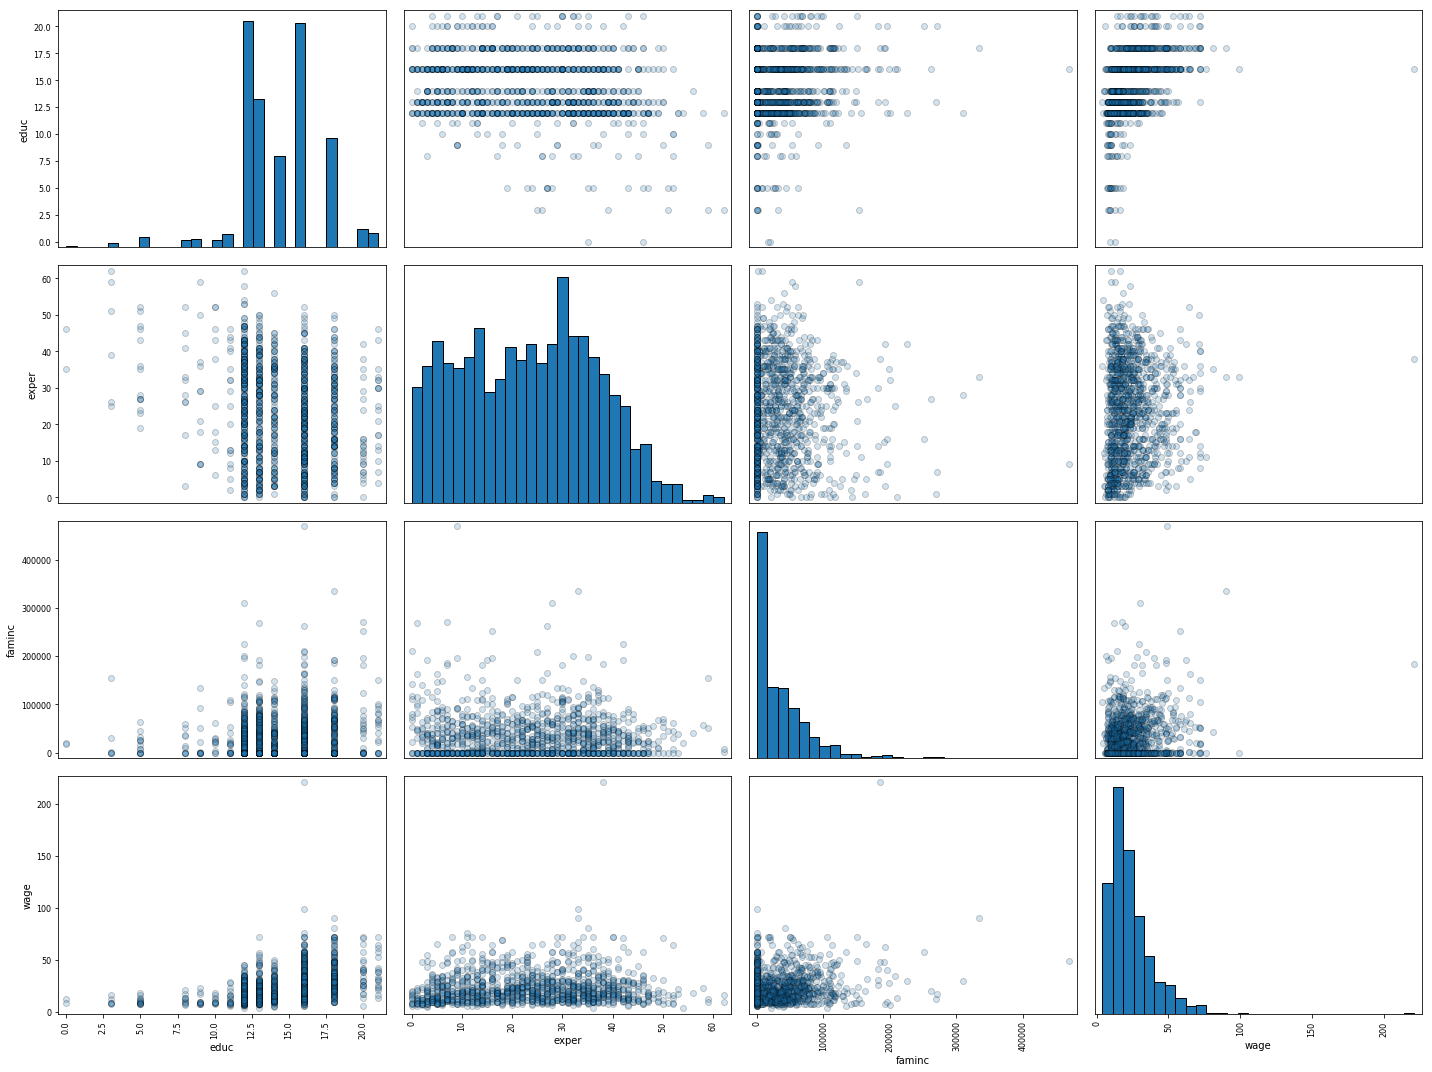

In [7]:
pd.plotting.scatter_matrix(dt4[['educ','exper', 'faminc', 'wage']], 
                           alpha = 0.2, figsize = (20, 15),
                           marker = "o",
                           hist_kwds = dict(edgecolor = "black", linewidth = 1, bins = 30),
                           edgecolor = "black")
plt.tight_layout()
plt.show()

Note that the diagonal elements are the histogram of the variables, while the **upper** and **lower** triangle of the plot matrix are the scatter-plots of the same variables. So, we will examine thediagonal plots and the plots in either the upper, or lower, triangle.

From the plots we can say that:

- None of the variables appear to be normally distributed;
- The `wage` and `faminc` data **appears** to be scattered more for larger values of`wage`.
- There is a clear relationship between:
        - `educ` and `exper`;
        - `educ` and `faminc`;
        - `educ` and `wage`;
- The relationship between `exper` and `faminc` is not as clear from the plots;

We also see that the correlation between explanatory variables is weaker, compared to the correlation between `educ` and the remaining variables.

In [8]:
print(dt4[['educ', 'exper', 'faminc', 'wage']].corr())

            educ     exper    faminc      wage
educ    1.000000 -0.202640  0.148319  0.455332
exper  -0.202640  1.000000 -0.023908  0.075248
faminc  0.148319 -0.023908  1.000000  0.170197
wage    0.455332  0.075248  0.170197  1.000000


We can also plot the scatter-matrix of the **whole dataset**:

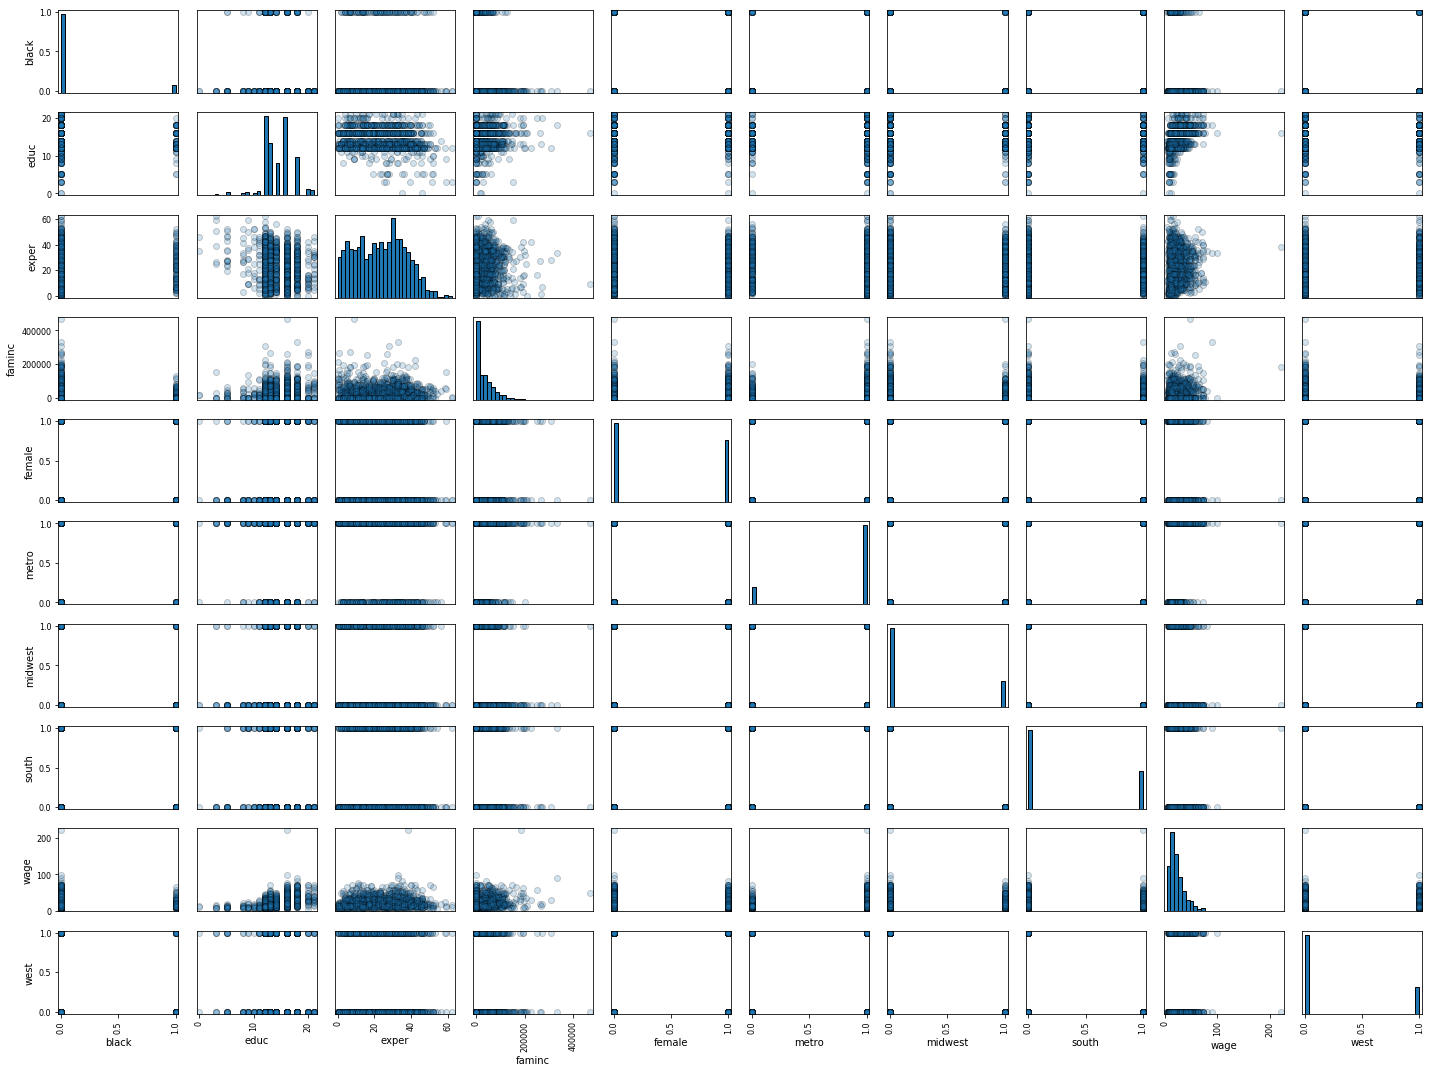

In [9]:
pd.plotting.scatter_matrix(dt4, alpha = 0.2, figsize = (20, 15), marker = "o",
                           hist_kwds = dict(edgecolor = "black", linewidth = 1, bins = 30),
                           edgecolor = "black")
plt.tight_layout()
plt.show()

Though for indicator variables these plots do not show much.

# TASK 2
## - Specify **one** regression in a mathematical formula notation based on economic theory. 
## - What coefficient sign do you expect $\beta_1,\beta_2,...$ to have? Explain. 

### Note: This is not necessarily the best regression - it is simply one you think makes economic sense.

We will quickly check if the regional indicator variables provided do not have all of the regions:

In [10]:
dt4[["south", "west", "midwest", "metro"]].head()

south  west  midwest  metro
0      0     1        0      1
1      0     0        1      1
2      0     0        0      1
3      0     0        1      1
4      0     1        0      1

In [11]:
np.min(dt4["south"] + dt4["west"] + dt4["midwest"])

0

Since they do not sum to one - we can include all of the variable in our model without falling into a dummy variable trap (otherwise we would need to exclude one regional indicator variable from the model and treat it as a base region).

We can also look at their **frequency table**:

In [12]:
pd.crosstab(index = dt4["south"] + dt4["west"] + dt4["midwest"], columns="count")

col_0  count
row_0       
0        210
1        990

Note that the maximum value is 1. If the maximum was 2 - this would show that some of the variables indicate something else, than the rest.

For example, if we include the `metro` indicator variable:

In [13]:
pd.crosstab(index = dt4["south"] + dt4["west"] + dt4["midwest"] + dt4["metro"], columns="count")

col_0  count
row_0       
0         36
1        352
2        812

We see that there are a number of rows that have a sum of 2, which means that `metro` indicates something else, rather than region.

In other words, `south`, `west` and `midwest` regions will be compared to a base `OTHER` region.

We will begin by specifying the following model:
$$
\begin{aligned}
\log(wage) &= \beta_0 + \beta_1 educ + \beta_2 educ^2 \\
&+ \beta_3 exper + \beta_4 exper^2 + \beta_5 metro + \beta_6 south + \beta_7 west + \beta_8 midwest + \beta_9 female + \beta_{10} black
\end{aligned}
$$

We expect the followign signs for the non-intercept coefficients:

- $\beta_1 > 0$ - additional years of education should increase the hourly `wage`;
- $\beta_2 > 0$ - generally it may be hard to say - with each additional year of education, the effect on `wage` may be lessened, however, if the additional year is for PhD-level education, then the additional year of education may have an **increased** effect on `wage`. For now, we will assume that is the case, i.e. $\beta_2 > 0$.
- $\beta_3 > 0$ - additional years of experience should increase the hourly `wage`;
- $\beta_4 < 0$ - generally, experience is **correlated with age**. Furthermore, **the lever of knowledge tends to even-out for each additional year of experience the more years of experience you have**. In other words, if you already have a lot of experience, then an additional year of experience would have a **lessened** (but not necessarily negative) effect on `wage`. Note: `exper^2` is alongside `exper`, so we do not know (as of right now), if there is a number of years of experience that results in a **decrease** in `wage`. We are assuming that it would result in an **increase, but at a lower rate** ($\beta_4 < 0$), compared to someone with less initial years of experience;
- $\beta_5 > 0$ - a [metropolitan](https://en.wikipedia.org/wiki/Metropolitan_area) is a highly dense population area. Generally, businesses are located in such high-density areas, and competition is higher. Consequently, we would expect someone from a metropolitan area to earn more than someone else, from the less-populated areas.
- $\beta_6, \beta_7, \beta_8$ - we are not sure of the sign as of yet. The **region may also be correlated with the metropolitan indicator variable**, as some regions could be less populated.
- $\beta_{9}, \beta_{10}$ - we are interested in evaluating if there is discrimination in the workforce (in which case these variables would be **negative**). Though it is important to note - as we will later see - the model may exhibit all sorts of problems - multicollinearity, autocorrelation, heteroskedasticity - which would result in **biased and/or insignificant** coefficients. **If our goal is to evaluate the effect - we should be careful that our model is correctly specified!**

We assume that other family income,`faminc`, should not affect the wage of a person, i.e. we treat it as **insignificant** variable, whose correlation may be **spurious** and as such, we do not include it in the model.

Note: it is possible to also include interaction variables in the model. As we already have 10 variables - we will skip this for now, but later on, we will examine some of these variables.

# TASK 3
## - Estimate the regression via OLS. 
## - Are the signs of $\beta_1,\beta_2,...$ the same as you expected?

In [14]:
mdl_0 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + west + midwest + female + black", data = dt4)
mdl_0_fit = mdl_0.fit()
print(mdl_0_fit.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     64.93
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          2.60e-105
Time:                        02:59:48   Log-Likelihood:                -750.01
No. Observations:                1200   AIC:                             1522.
Df Residuals:                    1189   BIC:                             1578.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5676      0

----

P.S. If we specify our own power function, we can estimate the same model:

In [15]:
def poly_var(x, p):
    return(np.array(x)**p)
#
print(smf.ols(formula = "np.log(wage) ~ educ + poly_var(educ, 2) + exper + poly_var(exper, 2) + metro + south + west + midwest + female + black", data = dt4).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     64.93
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          2.60e-105
Time:                        02:59:48   Log-Likelihood:                -750.01
No. Observations:                1200   AIC:                             1522.
Df Residuals:                    1189   BIC:                             1578.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5676      0

----

Going back to our case, we see that:

- the coefficients are the same as we would expect for `educ`, `exper` and their squared values;
- the coefficient of `metro` is also as we would expect;
- the regional coefficients are negative and **insignificant for west and midwest**, indicating that the regions themselves (since only one of them is significant) may not be indicative of different wages. On the other hand, it may be possible that people working in the `south` region earn significantly less than people in **all of the remaining regions** (other + west + midwest), however, **we can only check this if we remove the remaining regional variables and only leave the south variable**.
- coefficient sign of`female` is negative and significant, indicating possible discrimination in the work force (again, this is only the inital model, so we cannot be sure yet);
- coefficient sign of `black` is negatuve but it is **insignificant**, indicating that there is no racial discrimination.

# TASK 4
## - Test, which variables are statistically significant. 
## - Remove the insignificant variables (leave the initial estimated model as a separate variable).

We want to separately test the hypothesis that a coefficient is significant: 
$$
H_0: \beta_j = 0\\
H_1: \beta_j \neq 0
$$
The test is automatically carried out and the $t$-statistic and $p$-values are presented in the model summary output. 

Insignificant variables are those, whose $p$-value is greater than the 0.05 significance level:

In [16]:
print(mdl_0_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5676      0.170      9.215      0.000       1.234       1.901
educ                   0.0456      0.023      1.997      0.046       0.001       0.090
np.power(educ, 2)      0.0022      0.001      2.648      0.008       0.001       0.004
exper                  0.0285      0.004      7.981      0.000       0.022       0.036
np.power(exper, 2)    -0.0004   7.16e-05     -5.876      0.000      -0.001      -0.000
metro                  0.1210      0.035      3.459      0.001       0.052       0.190
south                 -0.0945      0.039     -2.407      0.016      -0.172      -0.017
west                  -0.0438      0.041     -1.070      0.285      -0.124       0.037
midwest               -0.0501      0.041     -1.216      0.224      -0.131       0.031
female                -0.1758      0.027   

We will begin by removing the insignificant variable (where the $p$-value is greater than 0.05) with the largest $p$-values - in this case it is the indicator variable `black`.

In [17]:
mdl_1 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + west + midwest + female", data = dt4)
mdl_1_fit = mdl_1.fit()
print(mdl_1_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5671      0.170      9.214      0.000       1.233       1.901
educ                   0.0452      0.023      1.981      0.048       0.000       0.090
np.power(educ, 2)      0.0022      0.001      2.679      0.007       0.001       0.004
exper                  0.0286      0.004      7.984      0.000       0.022       0.036
np.power(exper, 2)    -0.0004   7.16e-05     -5.875      0.000      -0.001      -0.000
metro                  0.1202      0.035      3.436      0.001       0.052       0.189
south                 -0.0982      0.039     -2.520      0.012      -0.175      -0.022
west                  -0.0431      0.041     -1.053      0.293      -0.123       0.037
midwest               -0.0493      0.041     -1.197      0.231      -0.130       0.031
female                -0.1780      0.027   

Next up, we will remove the indicartor variable `west`. Then we will remove the indicator variable `midwest`. We note that after doing so, the base group would be `other` + `west` + `midwest`.

In [18]:
mdl_2 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + midwest + female", data = dt4)
mdl_2_fit = mdl_2.fit()
print(mdl_2_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5358      0.167      9.171      0.000       1.207       1.864
educ                   0.0459      0.023      2.013      0.044       0.001       0.091
np.power(educ, 2)      0.0022      0.001      2.655      0.008       0.001       0.004
exper                  0.0287      0.004      8.031      0.000       0.022       0.036
np.power(exper, 2)    -0.0004   7.16e-05     -5.910      0.000      -0.001      -0.000
metro                  0.1180      0.035      3.380      0.001       0.050       0.186
south                 -0.0728      0.031     -2.378      0.018      -0.133      -0.013
midwest               -0.0242      0.034     -0.721      0.471      -0.090       0.042
female                -0.1783      0.027     -6.688      0.000      -0.231      -0.126


In [19]:
mdl_3 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + female", data = dt4)
mdl_3_fit = mdl_3.fit()
print(mdl_3_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5288      0.167      9.146      0.000       1.201       1.857
educ                   0.0452      0.023      1.982      0.048       0.000       0.090
np.power(educ, 2)      0.0022      0.001      2.695      0.007       0.001       0.004
exper                  0.0287      0.004      8.030      0.000       0.022       0.036
np.power(exper, 2)    -0.0004   7.15e-05     -5.906      0.000      -0.001      -0.000
metro                  0.1219      0.034      3.536      0.000       0.054       0.190
south                 -0.0640      0.028     -2.280      0.023      -0.119      -0.009
female                -0.1788      0.027     -6.713      0.000      -0.231      -0.127


The coefficient of the indicator variable `black` is insignificant, so we remove it as well.

# TASK 5
## - Write down the final (with significant variables) estimated regression formula.

From the model output we can write down the estimated model as:

$$
\begin{aligned}
\underset{(se)}{\widehat{\log(wage)}} &= \underset{(0.167)}{1.5288} + \underset{(0.023)}{0.0452} \cdot educ + \underset{(0.001)}{0.0022} \cdot educ^2 \\
&+ \underset{(0.004)}{0.0287} \cdot exper - \underset{(0.0001)}{0.0004} \cdot exper^2 \\
&+ \underset{(0.034)}{0.1219} \cdot metro - \underset{(0.028)}{0.0640} \cdot south - \underset{(0.027)}{0.1788} \cdot female 
\end{aligned}
$$

------

## **[START OF ADDITIONAL INFO]**

Furthermore, we can interpret the variables in the following way:

- An increasse in `educ` (education) by `1 year` results in an **increasing effect** on `wage` (i.e. the positive effect on `wage` is further increased depending on the initial level of `eudc`), **ceteris paribus**:
  - If `educ = 0` and then increases by $1$ year, then `wage` increases by $100 \cdot 0.0452 = 4.52\%$;
  - If `educ > 0` and then increases by $1$ year, then the difference in the change in `educ` results in:
  $$
  \begin{aligned}
  \underset{(se)}{\widehat{\log(wage)}} \bigg|_{educ + 1} - \underset{(se)}{\widehat{\log(wage)}} \bigg|_{educ} &= 0.0452 + 0.0022 \cdot (educ + 1)^2 - 0.0022 \cdot educ^2\\
  &= 0.0452 + 0.0022 \cdot (2 \cdot educ + 1)
  \end{aligned}
  $$
  then `wage` increases by $100 \cdot \left[ 0.0452 + 0.0022 \cdot (2 \cdot educ + 1) \right] \%$
- An increase in `exper` (years of experience) by `1 year` results in a **decreasing effect** on `wage` (i.e. the positive effect on `wage` is decreased depending on the initial level of `exper`, **ceteris paribus**:
  - If `exper = 0` increases by $1$ year, then `wage` increases by $100 \cdot 0.0287 = 2.87\%$;
  - If `exper > 0` increases by $1$ year, then the difference in the change in `exper` results in:
    $$
  \begin{aligned}
  \underset{(se)}{\widehat{\log(wage)}} \bigg|_{exper + 1} - \underset{(se)}{\widehat{\log(wage)}} \bigg|_{exper} &= 0.0287  - 0.0004 \cdot (exper + 1)^2 + 0.0004 \cdot exper^2\\
  &= 0.0287  - 0.0004 \cdot (2 \cdot exper + 1)
  \end{aligned}
  $$
  then `wage` **changes** by $100 \cdot \left[ 0.0452 + 0.0022 \cdot (2 \cdot exper + 1) \right] \%$.
  - We may be interested in finding whether there are values of `exper` that result in a maximum (or minimum) value of `wage`, **ceteris paribus**. Taking the partial derivative (calculating the marginal effect) and equating it to zero yields:
$$
\begin{aligned}
\dfrac{\partial {\widehat{\log(wage)}}}{\partial exper} &= 0.0287  - 0.0004 \cdot 2 \cdot educ = 0.0287  - 0.0008 \cdot exper = 0
\end{aligned}
$$

In [20]:
print(mdl_3_fit.params)
print("Maximum Wage when exper = " + str(mdl_3_fit.params[3] / (-mdl_3_fit.params[4] * 2)))

Intercept             1.528819
educ                  0.045156
np.power(educ, 2)     0.002204
exper                 0.028693
np.power(exper, 2)   -0.000423
metro                 0.121921
south                -0.063999
female               -0.178835
dtype: float64
Maximum Wage when exper = 33.95321196698675


So, when $exper = 33.95$, `wage` will be at its **maximum** since $\dfrac{\partial^2 {\widehat{\log(wage)}}}{\partial^2 exper} < 0$.

Note that we used the **exact values** instead of the rounded values from the formulas. Reason being that the rounding error would give us a different value:

In [21]:
0.0287 / 0.0008

35.875

Which would not be the same, one we try with to verify the results with the actual data.

  - We can further examine when a unit increase in `exper` results in **no change in wage**:
  $$
  \begin{aligned}
  0.0287  - 0.0004 \cdot (2 \cdot educ + 1) &= 0
  \end{aligned}
  $$

In [22]:
zero_inc = (mdl_3_fit.params[3] / (-mdl_3_fit.params[4]) - 1) / 2
print(zero_inc)

33.45321196698675


So, if the initial value of $exper = 33.45$, `wage` would not change with an additional **unit** increase in `exper`. **Remember that`exper` can only be integer-valued**.

Furthermore, for $exper > 33.45$, `wage` would **decrease** from a unit increase in `exper`. We can verify this by taking the initial value `exper = 36`:

In [23]:
# Repeat the first row twice:
tst_dt = dt4.iloc[[0,0], :]
# Reset row index numbering to avoid duplicate row index numbers
tst_dt = tst_dt.reset_index(drop = True)
# Set `exper` column values:
tst_dt.loc[:, "exper"] = [36, 37]
# Print the sample data:
print(tst_dt)

   black  educ  exper  faminc  female  metro  midwest  south   wage  west
0      0    13     36       0       1      1        0      0  44.44     1
1      0    13     37       0       1      1        0      0  44.44     1


Note the **ceteris paribus** condition - **there is only only a unit change in `exper`, while the remaining values are do not change**. 

Now, we can calculate and compare the predicted values:

In [24]:
tst_pred = mdl_3_fit.predict(tst_dt)
print(tst_pred)

0    2.916816
1    2.914663
dtype: float64


In [25]:
np.diff(tst_pred)

array([-0.00215223])

which would be a $0.215\%$ **decrease in wage** for someone with 36 years of experience earning an additional year of experience.

This can be verified manually, by taking the exponents of the predicted values (since these predicted values are from the log-linear model) and caluclating their percentage change:
$$
\dfrac{WAGE_{NEW} - WAGE_{OLD}}{WAGE_{OLD}} \cdot 100
$$

In [26]:
np.diff(np.exp(tst_pred)) / np.exp(tst_pred[0]) * 100 

array([-0.21499112])

We note that this is an **approximation** only, and not a true equality between logarithm differences and percentage change. 

**It is very close when the percentage change is small, but for larger percentage changes, it may differ greatly.**

- Another example when the wage would still increase is when someone has 33 years of experience and it increases to 34 (since the maximum is attained when `exper = 34.95`):

In [27]:
tst_dt.loc[:, "exper"] = [33, 34]
print(tst_dt)

   black  educ  exper  faminc  female  metro  midwest  south   wage  west
0      0    13     33       0       1      1        0      0  44.44     1
1      0    13     34       0       1      1        0      0  44.44     1


In [28]:
tst_pred = mdl_3_fit.predict(tst_dt)
print(tst_pred)

0    2.918202
1    2.918585
dtype: float64


In [29]:
np.diff(tst_pred)

array([0.000383])

- On the other hand, if we were to **ignore** that `exper` is only integer valued, then we can verify the point, where `wage` does not change from a unit incease in `exper`:

In [30]:
tst_dt.loc[:, "exper"] = [zero_inc, zero_inc + 1]
print(tst_dt)

   black  educ      exper  faminc  female  metro  midwest  south   wage  west
0      0    13  33.453212       0       1      1        0      0  44.44     1
1      0    13  34.453212       0       1      1        0      0  44.44     1


In [31]:
tst_pred = mdl_3_fit.predict(tst_dt)
print(tst_pred)

0    2.91848
1    2.91848
dtype: float64


In [32]:
np.diff(tst_pred)

array([0.])

- Continuing our coefficient interpretation:
 - A person from a metropolitan area (`metro = 1`) earns around $100 \cdot 0.1219 = 12.19\%$ more than someone **not from a metro area**, ceteris paribus;
 - A person from the south region (`south = 1`) earns around $100 \cdot 0.0640 = 6.4\%$ **less** (since the coefficient is $-0.0640 < 0$) than someone **not from the south**.     
   - Take note that we have removed other regional coefficients, and as a result, we are left with only one regional indicator. Consequently, we only compare someone from the south, versus someone not from the south (they could be from either west, midwest, or another region). 
   - If we were to **leave other regional indicator variables**, then the south indicator variable would indicate how much more/less someone from the south earns compared to **some other base region cateogry, which does NOT include west or midwest**.
   - As a result, this coefficient also indicates that the wages in the south are lower than wages in the rest of the country.
 - If the person is female (`female = 1`), then they earn around $100 \cdot 0.1788 = 17.88\%$ **less** than someone who is not female.
 
## **[END OF ADDITIONAL INFO]**

---

# TASK 6
## - Examine the residual plots. 
## - Test for normality, autocorrelation, heteroskedasticity. 
## - Do the residuals violate our (MR.3) - (MR.6) model assumptions?

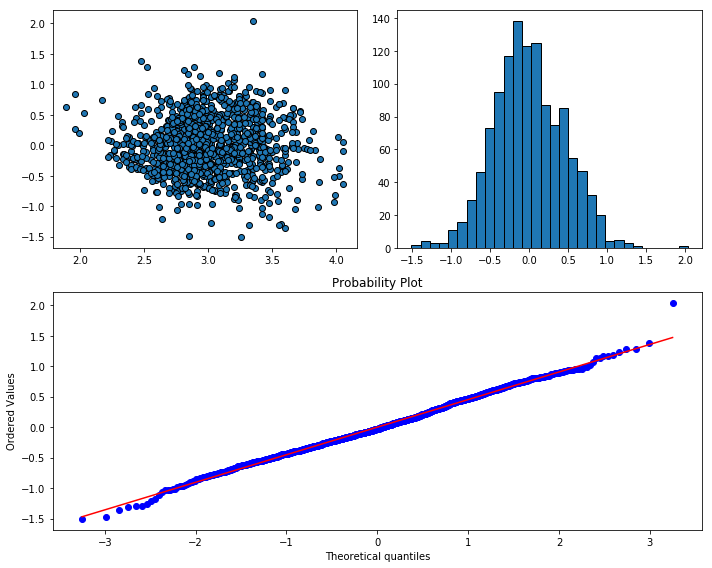

In [33]:
fig = plt.figure(num = 2, figsize = (10, 8))
# Plot fitted vs residual plots:
ax = fig.add_subplot(2, 2, 1)
ax.plot(mdl_3_fit.fittedvalues, mdl_3_fit.resid, linestyle = "None", marker = "o", markeredgecolor = "black")
# Plot the residual histogram
ax = fig.add_subplot(2, 2, 2)
ax.hist(mdl_3_fit.resid, bins = 30, edgecolor = "black")
# Plot the residual Q-Q plot:
ax = fig.add_subplot(2, 1, 2)
stats.probplot(mdl_3_fit.resid, dist = "norm", plot = ax)
# Fix layout in case the labels do overlap:
plt.tight_layout()
plt.show()

We can see that:

- From the residual vs. fitted plot - the residuals appear to havea a constant variance, though there are some points that have large residual values for low fitted values (fitted values are on the horizontal axis), and low residual values for very large fitted values, but those points do not make up a majority (the heteroskedasticity test will help us answer whether their variance is the same across observations).
- From fhe residual histogram the residuals appear to be normal, though the histogram does appear to have a longer right tail;
- The residuals in the Q-Q plot appear to fall along a straight line with the theoretical quantiles of a normal distribution, **except** for one point (which is most likely an outlier).

Next, we move on to testing a few hypothesis.

### Homoskedasticity tests

The hypothesis that we want to test is:
$$
\begin{cases}
H_0&: \gamma_1 = 0 \text{ (residuals are homoskedastic)}\\
H_1&: \gamma_1 \neq 0 \text{ (residuals are heteroskedastic)}
\end{cases}
$$

We will begin with the **Breusch-Pagan Test**:

In [34]:
import statsmodels.stats.diagnostic as sm_diagnostic
#
bp_test = sm_diagnostic.het_breuschpagan(resid = mdl_3_fit.resid, 
                                     exog_het = pd.DataFrame(mdl_3.exog, columns = mdl_3.exog_names))
print(bp_test)

(32.8407785836462, 2.8347092444455944e-05, 4.791390357203256, 2.4871814638391178e-05)


The BP test in `Python` returns the values in the followin order:
- `lm`– lagrange multiplier statistic
- `lm_pvalue` – p-value of lagrange multiplier test
- `fvalue` – f-statistic of the hypothesis that the error variance does not depend on x
- `f_pvalue` – p-value for the f-statistic

We are interested in the $LM$ statistic and its associated p-value, so we need the second element in the array. We have that the $p$-value < 0.05, so we reject the null hypothesis that the residuasl are homoskedastic. Which means that the residuals are heteroskedastic.

Next, we look at the **Goldfeld-Quandt Test** results:

In [35]:
# Goldfeld–Quandt Test
print(sm_diagnostic.het_goldfeldquandt(y = mdl_3_fit.model.endog, x = mdl_3_fit.model.exog, alternative = "two-sided"))

(0.9324718384269218, 0.3952565949130827, 'two-sided')


The $p$-value > 0.05, so we have no grounds to reject the null hypothesis and conclude that the residuals are homoskedastic.

Finally, we look at the **White Test** results:

In [36]:
# White Test
print(sm_diagnostic.het_white(resid = mdl_3_fit.resid, exog = mdl_3_fit.model.exog))

(64.38594677103491, 0.0002626979789954135, 2.209294362561757, 0.00020467117617535834)


The White test returns the results in the same order as the **BP** test. So, the $p$-value = 0.00026269798 < 0.05, so we reject the null hypothesis and conclude that the rsiduals are heteroskedastic.

### **From these test results we can say that the residuals are heteroskedastic**.

#### Autocorrelation Tests

The hypothesis that we want to test is:
$$
\begin{cases}
H_0&:\text{the errors are serially uncorrelated}\\
H_1&:\text{the errors are autocorrelated (the exact order of the autocorrelation depends on the test carried out)}
\end{cases}
$$

We will begin with the **Durbin-Watson Test**, where the alternative hypothesis is that the **autocorrelation is of order 1**:

In [37]:
import statsmodels.stats.stattools as sm_tools
# Durbin–Watson Test
print(sm_tools.durbin_watson(mdl_3_fit.resid))

2.022124578571145


The **DW** statistic is close to 2, so we do not reject the null hypothesis that there is no serial correlation.

Next up is the **Breusch-Godfrey Test**, where we can select the autocorrelation order ourselves. We have selected a 2nd order autocorrelation:

In [38]:
print(sm_diagnostic.acorr_breusch_godfrey(mdl_3_fit, nlags = 2))

(0.2084601561308297, 0.9010179691000353, 0.10337945282885344, 0.9017928217545959)


The **BG** test returns the values in the same order as the **BP** test. the $p$-value = 0.901018 > 0.05, so we have no grounds to reject the null hypothesis of no autocorrelation.

We could test with higher order autocorrelation and examine the results, lets try with up to order 20:

In [39]:
for i in range(2, 21):
    print("BG Test for autocorrelation order = "+str(i)+"; p-value = " + str(np.round(sm_diagnostic.acorr_breusch_godfrey(mdl_3_fit, nlags = i)[1], 5)))

BG Test for autocorrelation order = 2; p-value = 0.90102
BG Test for autocorrelation order = 3; p-value = 0.30049
BG Test for autocorrelation order = 4; p-value = 0.28286
BG Test for autocorrelation order = 5; p-value = 0.24209
BG Test for autocorrelation order = 6; p-value = 0.24766
BG Test for autocorrelation order = 7; p-value = 0.33798
BG Test for autocorrelation order = 8; p-value = 0.2663
BG Test for autocorrelation order = 9; p-value = 0.35112
BG Test for autocorrelation order = 10; p-value = 0.37166
BG Test for autocorrelation order = 11; p-value = 0.41263
BG Test for autocorrelation order = 12; p-value = 0.47018
BG Test for autocorrelation order = 13; p-value = 0.41332
BG Test for autocorrelation order = 14; p-value = 0.485
BG Test for autocorrelation order = 15; p-value = 0.55692
BG Test for autocorrelation order = 16; p-value = 0.50146
BG Test for autocorrelation order = 17; p-value = 0.37439
BG Test for autocorrelation order = 18; p-value = 0.31878
BG Test for autocorrelati

As we can see, we have no grounds to reject the null hypothesis of autocorrelation in any of the cases.

### **From these test results we can conclude that the residuals are not serially correlated**.

#### Normality Tests

The hypothesis that we want to test is:
$$
\begin{cases}
H_0&:\text{residuals follow a normal distribution}\\
H_1&:\text{residuals do not follow a normal distribution}
\end{cases}
$$

We will carry our the following tests and combine their $p$-values a single output:

In [40]:
norm_tests = ["Anderson-Darling", 
              "Shapiro-Wilk", 
              "Kolmogorov-Smirnov", 
              "Cramer–von Mises", 
              "Jarque–Bera"]

In [41]:
import skgof as skgof
#
norm_test = pd.DataFrame()
norm_test["p_value"] = [
    sm_diagnostic.normal_ad(x = mdl_3_fit.resid)[1],
    stats.shapiro(x = mdl_3_fit.resid)[1],
    sm_diagnostic.kstest_normal(x = mdl_3_fit.resid, dist = "norm")[1],
    skgof.cvm_test(data = mdl_3_fit.resid, dist = stats.norm(0, np.sqrt(np.var(mdl_3_fit.resid))))[1],
    sm_tools.jarque_bera(mdl_3_fit.resid)[1]
]
norm_test["Test"] = norm_tests
print(norm_test)

    p_value                Test
0  0.004300    Anderson-Darling
1  0.009814        Shapiro-Wilk
2  0.008837  Kolmogorov-Smirnov
3  0.243253    Cramer–von Mises
4  0.062916         Jarque–Bera


We see that the $p$-value is less than the $5\%$ significance level for the **Anderson-Darling**, **Shapiro-Wilk** and **Kolmogorov-Smirnov** tests, where we would reject the null hypothesis of normality. On the other hand the $p$-value is greater than 0.05 for **Cramer-von Mises** and **Jarque-Bera** tests, where we would not reject the null hypothesis of normality.

As indicated in the lecture notes, that Shapiro–Wilk has the best power for a given significance, furthermore, 3 our of 5 tests suggest non-normal residuals, so we will go with their results.

### **From these test results we can conclude that the residuals are not normally distributed**.

**OVERALL CONCLUSIONS**:
 - Residuals are not serially correlated (**asuumption (MR.3) is NOT violated**);
 - Residuals are Heteroskedastic (**assumption (MR.4) IS violated**);
 - Residuals are non-normally distributed (**assumption (MR.6) IS violated**).
 
Assumption **(MR.5)**  is related to multicollinearity and will be examined in a later TASK. But from what we have seen so far, almost all of the coefficients are statistically significant, with correct signs. Furthermore, since we were able to estimate the model via OLS, there is not exact collinearity (i.e. no exact linear dependence) between the regressors. So, there may be no collinear variables in our model.

-----
-----
-----

## Comparison With Univariate Regression Model Results

If we look back at our final univariate regression model - the log-linear model:
$$
\underset{(se)}{\widehat{\log(\text{wage})}} = \underset{(0.0702)}{1.5968} + \underset{(0.0048)}{0.0988} \cdot \text{educ}
$$
We can estimate it here as well, and re-examine its residuals:

In [42]:
lm_univar = smf.ols(formula = "np.log(wage) ~ educ", data = dt4)
lm_univar_fit = lm_univar.fit()
print(lm_univar_fit.summary2().tables[1])

              Coef.  Std.Err.          t         P>|t|    [0.025    0.975]
Intercept  1.596835  0.070180  22.753370  1.530466e-95  1.459146  1.734525
educ       0.098753  0.004842  20.394367  1.344896e-79  0.089253  0.108254


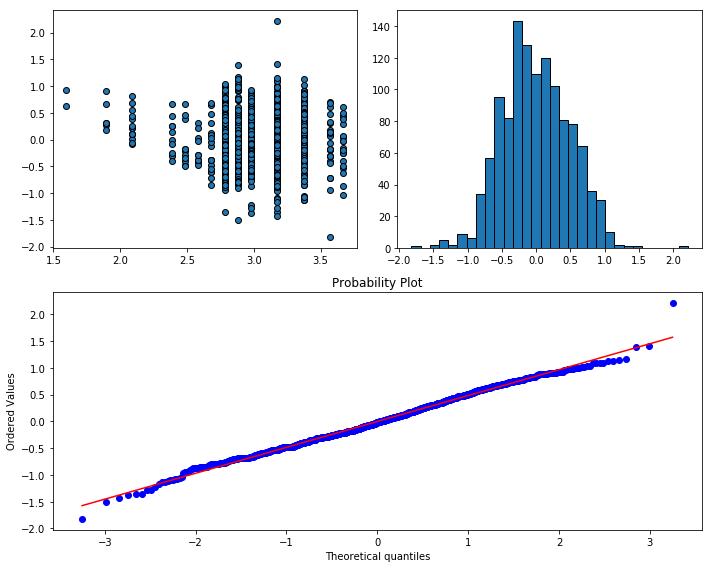

In [43]:
fig = plt.figure(num = 3, figsize = (10, 8))
# Plot fitted vs residual plots:
ax = fig.add_subplot(2, 2, 1)
ax.plot(lm_univar_fit.fittedvalues, lm_univar_fit.resid, linestyle = "None", marker = "o", markeredgecolor = "black")
# Plot the residual histogram
ax = fig.add_subplot(2, 2, 2)
ax.hist(lm_univar_fit.resid, bins = 30, edgecolor = "black")
# Plot the residual Q-Q plot:
ax = fig.add_subplot(2, 1, 2)
stats.probplot(lm_univar_fit.resid, dist = "norm", plot = ax)
# Fix layout in case the labels do overlap:
plt.tight_layout()
plt.show()

Compared to the univariate model:
    
- **The residual vs fitted value plot visually looks better in the multivariate model**;
- The residual histogram is similar, but visually looks a bit better in the multivariate model;
- The residual Q-Q plots are similar in both cases - the outlier still remains in the data.

Again note that the fitted values are on the horizontal axis, which also highlights another interesting poitns regarding the range of attainable fitted values in these models.

Looking at the residual vs fitted value plot, the number of fitted values, greater than 3.2, but less than 3.35 is:

- For the univariate regression with one variable:

In [44]:
len(lm_univar_fit.fittedvalues[np.logical_and(lm_univar_fit.fittedvalues > 3.2, lm_univar_fit.fittedvalues < 3.35)])

0

- For the multiple regression:

In [45]:
len(mdl_3_fit.fittedvalues[np.logical_and(mdl_3_fit.fittedvalues > 3.2, mdl_3_fit.fittedvalues < 3.35)])

140

**By using the multivariate regression mode specification we now get fitted values, which are more evenly scattered across their interval, whereas in the univaraite case, we had fitted values clustered along a limited range**.

-----
-----
-----

# TASK 7
## - Add interaction variables to your model, provide an interpretation for what kind of sign you expect. 
## - Then, estimate the model and check if they are significant. If they are - re-examine the residuals.

To make everything easier to follow, we will examine the interaction terms one-by one, so as not to overwhelm with too many variables in the model.

- It may be interesting to include the interaction term:
$$
female \times black
$$
to see if there is a **different** discrimination for females based on race.

In [46]:
mdl_4 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + female*black", data = dt4)
mdl_4_fit = mdl_4.fit()
print(mdl_4_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.347    
Dependent Variable: np.log(wage)     AIC:                1521.7169
Date:               2018-11-29 02:59 BIC:                1572.6177
No. Observations:   1200             Log-Likelihood:     -750.86  
Df Model:           9                F-statistic:        71.92    
Df Residuals:       1190             Prob (F-statistic): 6.83e-106
R-squared:          0.352            Scale:              0.20637  
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           1.5286   0.1673  9.1391 0.0000  1.2005  1.8568
educ                0.0455   0.0228  1.9963 0.0461  0.0008  0.0903
np.power(educ, 2)   0.0022   0.0008  2.6638 0.0078  0.0006  0.0038
exper               0.0287   0.0036  8.0230 0.0000  0.0217  0.0357
np.power(expe

**Both `black` and `female * black` are insignificant, so we can remove them from the regression.**

**Alternatively, we may want to carry out an $F$-test** to test the joint hypothesis that:
$$
\begin{cases}
H_0&: \beta_{female} = 0, \beta_{black} = 0, \beta_{female \times black} = 0\\
H_1&: \text{at least one of the tested parameters is not zero}
\end{cases}
$$

If fail to reject the null hypothesis, then both race and gender have no significant effect on the model.

In [47]:
print(mdl_4_fit.f_test("female=0, black=0, female:black=0"))

<F test: F=array([[15.18786375]]), p=1.0550933715285045e-09, df_denom=1190, df_num=3>


Since the $p$-value < 0.05, we reject the null hypothesis and conclude that at least one of the variables is statistically significant.

If we only look at the joint hypothesis for `black` and `female:black`:

In [48]:
print(mdl_4_fit.f_test("black=0, female:black=0"))

<F test: F=array([[0.28004941]]), p=0.755796192994751, df_denom=1190, df_num=2>


Then we do not reject the null hypothesis that **both `black` and `female:black` are not statistically significant** and thus we can remove them **both** from our model.

We can also do this with the **ANOVA** test: by specifying the **restricted model under the null**:

In [49]:
mdl_4_restricted = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south", data = dt4)
mdl_4_restricted_fit = mdl_4_restricted.fit()
print(sm.stats.anova_lm(mdl_4_restricted_fit, mdl_4_fit))

   df_resid         ssr  df_diff  ss_diff          F        Pr(>F)
0    1193.0  254.984929      0.0      NaN        NaN           NaN
1    1190.0  245.581909      3.0  9.40302  15.187864  1.055093e-09


c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [50]:
mdl_4_restricted = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + female", data = dt4)
mdl_4_restricted_fit = mdl_4_restricted.fit()
print(sm.stats.anova_lm(mdl_4_restricted_fit, mdl_4_fit))

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0    1192.0  245.697497      0.0       NaN       NaN       NaN
1    1190.0  245.581909      2.0  0.115588  0.280049  0.755796


c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


We see that we get the exact same $F$-statistic and the exact same $p$-value. So, we can use either method to carry out the $F$-test for multiple coefficient significance (i.e. multiple restricitons).

Note: In case of `RunTime Warning` - these specific `RuntimeWarnings` are coming from scipy.stats.distributions, but are “by design”. In statsmodels these “invalid” RuntimeWarnings should not cause problems

- We may also be interested if an additional year of education has a different effect based on gender: $female \times educ$. Since the coefficient of `female` is negative, it would be interesting to see, whether a higher education has a different effect based on a persons gender.

In [51]:
mdl_4 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + female*educ", data = dt4)
mdl_4_fit = mdl_4.fit()
print(mdl_4_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.350    
Dependent Variable: np.log(wage)     AIC:                1515.0496
Date:               2018-11-29 02:59 BIC:                1560.8603
No. Observations:   1200             Log-Likelihood:     -748.52  
Df Model:           8                F-statistic:        81.88    
Df Residuals:       1191             Prob (F-statistic): 7.40e-108
R-squared:          0.355            Scale:              0.20540  
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           1.5876   0.1688  9.4031 0.0000  1.2563  1.9189
educ                0.0446   0.0227  1.9608 0.0501 -0.0000  0.0892
np.power(educ, 2)   0.0019   0.0008  2.3264 0.0202  0.0003  0.0035
exper               0.0289   0.0036  8.1096 0.0000  0.0219  0.0359
np.power(expe

We note that the $p$-value of `educ` is close to 0.05. On the other hand the interaction variable between gender and education is significant (as well as the squared education, $educ^2$), so we will leave the variables included. We will further motivate this decision via the $F$-test.

Looking at the $F$-test for the hypothesis:
$$
\begin{cases}
H_0&: \beta_{educ} = 0, \beta_{female \times educ} = 0\\
H_1&: \text{at least one of the tested parameters is not zero}
\end{cases}
$$

In [52]:
print(mdl_4_fit.f_test("educ=0, female:educ=0"))

<F test: F=array([[4.57291126]]), p=0.010509846687314363, df_denom=1191, df_num=2>


The $p$-value is less than 0.05, so we reject the null hypothesis and conclude that at least one variable is statistically significant.

However, removing only `educ`, but leaving the interaction term would further complicate interpretation, especially since its $p$ value is so close to the $5\%$ significance level. If we relax the significance level, the nall the variables are statistically significant **at the 0.1 ($10\%$) significance level**.

**INTERPRETATION**:

Looking at the model coefficients:
$$
\begin{aligned}
\underset{(se)}{\widehat{\log(wage)}} &= \underset{(0.1688)}{1.5876} + \underset{(0.0227)}{0.0446} \cdot educ + \underset{(0.0008)}{0.0019} \cdot educ^2 \\
&+ \underset{(0.0036)}{0.0289} \cdot exper - \underset{(0.0001)}{0.0004} \cdot exper^2 \\
&+ \underset{(0.0345)}{0.1254} \cdot metro - \underset{(0.0280)}{0.0653} \cdot south \\
&- \underset{(0.1391)}{0.4903} \cdot female + \underset{(0.0095)}{0.0217} \cdot \left(female \times educ\right)
\end{aligned}
$$

or, with a little bit of rearranging, to highlight the effect of gender, we get:
$$
\begin{aligned}
\underset{(se)}{\widehat{\log(wage)}} &= \underset{(0.1688)}{1.5876} + \underset{(0.0227)}{0.0446} \cdot educ + \underset{(0.0008)}{0.0019} \cdot educ^2 \\
&+ \underset{(0.0036)}{0.0289} \cdot exper - \underset{(0.0001)}{0.0004} \cdot exper^2 \\
&+ \underset{(0.0345)}{0.1254} \cdot metro - \underset{(0.0280)}{0.0653} \cdot south \\
&+ \left(\underset{(0.0095)}{0.0217} \cdot educ  - \underset{(0.1391)}{0.4903}\right) \cdot female
\end{aligned}
$$

a possible interpretation could be as follows: if the person is female, then their $\log(wage)$ differs by $\left(\underset{(0.0095)}{0.0217} \cdot educ  - \underset{(0.1391)}{0.4903}\right)$, compared to males (or **the base** non-female **group**), ceteris paribus.

By specifying this model we can see how much education offsets discrimination based on gender. Notice that in this case, if `educ = 0`, then there is a large difference in wage - the wage is **lwoer** by around $100 \cdot 0.4903 = 49.03 \%$ for females.

**HOWEVER**, if we look at the sample data:

In [53]:
dt4.loc[dt4["educ"] == 0]

black  educ  exper  faminc  female  metro  midwest  south   wage  west
812       0     0     46   20000       0      0        0      1  12.50     0
1082      0     0     35   17000       1      1        0      0   9.19     1

We only have **two cases** when `educ = 0` - **ONE FOR FEMALES** and **ONE FOR MALES**. Looking at the difference:

In [54]:
(12.50 - 9.19)/9.19

0.36017410228509256

is around $36\%$, however, other factors, like `metro`, `south` and `exper` are **different**, while the coefficient in our model, holds these values cosntant (i.e. the same), with only gender being different (this explains the $49.03\%$ value in our model).

Having so few datapoints does not reflect the case when `educ = 0`, hence we should be careful when identifying it.


- Yet another possible interaction term is between the the regional indicator(s) and education - since education quality most likely differs depending on the region (especially concerning university quality), it may have a significant effect: $south \times educ$.

In [55]:
mdl_4 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south*educ + female*educ", data = dt4)
mdl_4_fit = mdl_4.fit()
print(mdl_4_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5910      0.173      9.171      0.000       1.251       1.931
educ                   0.0444      0.023      1.945      0.052      -0.000       0.089
np.power(educ, 2)      0.0019      0.001      2.316      0.021       0.000       0.004
exper                  0.0290      0.004      8.105      0.000       0.022       0.036
np.power(exper, 2)    -0.0004   7.15e-05     -5.953      0.000      -0.001      -0.000
metro                  0.1253      0.034      3.634      0.000       0.058       0.193
south                 -0.0772      0.141     -0.548      0.584      -0.354       0.199
south:educ             0.0008      0.010      0.086      0.931      -0.018       0.020
female                -0.4911      0.140     -3.521      0.000      -0.765      -0.217
female:educ            0.0218      0.010   

We see that the interaction variable between `south` and `educ` is insignificant, so we will not include it in our model.

- There may also be other interaction variables, like $south \times female \times educ$, or $metro \times south$, or many more. But we will not go through all of these step-by-step, as we have done so previously to save space and make this python notebook readable. We have tried a couple more of these interaction terms and arrived at the following model:

In [56]:
mdl_4 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + south + metro*female*educ", data = dt4)
mdl_4_fit = mdl_4.fit()
print(mdl_4_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.0524      0.240      8.539      0.000       1.581       2.524
educ                   0.0134      0.026      0.522      0.602      -0.037       0.064
np.power(educ, 2)      0.0016      0.001      1.958      0.050   -3.04e-06       0.003
exper                  0.0289      0.004      8.121      0.000       0.022       0.036
np.power(exper, 2)    -0.0004   7.13e-05     -5.940      0.000      -0.001      -0.000
south                 -0.0699      0.028     -2.497      0.013      -0.125      -0.015
metro                 -0.4873      0.220     -2.214      0.027      -0.919      -0.056
female                -1.3713      0.357     -3.842      0.000      -2.072      -0.671
metro:female           1.0304      0.385      2.678      0.008       0.276       1.785
metro:educ             0.0461      0.016   

The $F$-test for the joint significance for education significance:
$$
\begin{cases}
H_0&: \beta_{educ} = \beta_{educ^2} = \beta_{female \times educ} = \beta_{metro \times educ} = \beta_{metro \times female \times educ}= 0\\
H_1&: \text{at least one of the tested parameters is not zero}
\end{cases}
$$

In [57]:
print(mdl_4_fit.params.index.format())

['Intercept', 'educ', 'np.power(educ, 2)', 'exper', 'np.power(exper, 2)', 'south', 'metro', 'female', 'metro:female', 'metro:educ', 'female:educ', 'metro:female:educ']


In [58]:
print(mdl_4_fit.f_test("educ=0, np.power(educ, 2) = 0, female:educ=0, metro:educ=0, metro:female:educ=0"))

<F test: F=array([[104.68810134]]), p=1.239384726864219e-91, df_denom=1188, df_num=5>


With $p$-value < 0.05, we reject the null hypothesis and conclude that `educ` is statistically significant in our model. 

**On the other hand, we could remove the the squared value of `educ`. Though we will examine this in more detail in the collinearity task.**

Furthermore, testing the significance of only the $educ$ and its polynomial $educ^2$:
$$
\begin{cases}
H_0&: \beta_{educ} = \beta_{educ^2} = 0\\
H_1&: \text{at least one of the tested parameters is not zero}
\end{cases}
$$
yields:

In [59]:
print(mdl_4_fit.f_test("educ=0, np.power(educ, 2) = 0"))

<F test: F=array([[8.6567857]]), p=0.0001851561190922158, df_denom=1188, df_num=2>


a $p$-value < 0.05, which means that we still reject the null hypothesis and conclude that education has a significant effect on `wage`.

Finally, the $R^2_{adj}$ is:

In [60]:
print(mdl_4_fit.rsquared_adj)

0.35426221625874343


**Interaction terms are not restricted to indicator variables - we can include interactions where BOTH variables are non-indivcators** 

Consequently, let us look at yet another **interaction** variable, but this time between `edu` and `exper`. 

**The motivation for including this interaction variable** can be formulated as a question:

- Does an additional year of experience have a magnified effect based on years of education?
- Does an additional year of education have a magnified effect based on the years of experience?
- Does a unit increase in education result in a change in the effectiveness of experience on wage? (e.g. an increase in education lowers the effect (i.e. the coefficient) of experience)
- Does a unit increase in experience result in a change in the effectiveness of education on wage? (e.g. an increase in experience lowers the effect (i.e. the coefficient) of education)

In other words, we want to include an additional variable, $educ \times exper$ in our model:

In [61]:
mdl_4 = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + south + metro*female*educ + educ:exper", data = dt4)
mdl_4_fit = mdl_4.fit()
print(mdl_4_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0.324      4.255      0.000       0.743       2.016
educ                   0.0768      0.033      2.337      0.020       0.012       0.141
np.power(educ, 2)      0.0004      0.001      0.475      0.635      -0.001       0.002
exper                  0.0479      0.007      6.735      0.000       0.034       0.062
np.power(exper, 2)    -0.0005   7.41e-05     -6.588      0.000      -0.001      -0.000
south                 -0.0703      0.028     -2.519      0.012      -0.125      -0.016
metro                 -0.4710      0.219     -2.147      0.032      -0.901      -0.041
female                -1.3834      0.356     -3.889      0.000      -2.081      -0.686
metro:female           1.0481      0.383      2.734      0.006       0.296       1.800
metro:educ             0.0447      0.016   

The coefficient of the interaction term `educ:exper` is statistically significant ($p$-value < 0.05).

**INTERPRETATION**:

This means that we can write our model as (note, we will keep a general notation to make it easier to see what we want to explain):
$$
\begin{aligned}
\log(wage) &= \beta_0 + \beta_1 educ + \beta_2 educ^2  + \beta_3 exper + \beta_4 exper^2 \\
&+ \beta_5 metro + \beta_6 south + \beta_7 west + \beta_8 midwest + \beta_9 female + \beta_{10} black \\
&+ \beta_{11} \left( educ \times exper \right) + \epsilon
\end{aligned}
$$

We can re-write this equation as:
$$
\begin{aligned}
\log(wage) &= \beta_0 + \left(\beta_1 + \beta_{11} exper \right)educ + \beta_2 educ^2  + \beta_3 exper + \beta_4 exper^2 \\
&+ \beta_5 metro + \beta_6 south + \beta_7 west + \beta_8 midwest + \beta_9 female + \beta_{10} black \\
&+ \epsilon
\end{aligned}
$$

or as:


So, the coefficient $\beta_{11}$ can be interpreted as the **change in effectiveness** of education for a one unit increase in experience.

Alternatively, rewriting the equation as:
$$
\begin{aligned}
\log(wage) &= \beta_0 + \beta_1 educ + \beta_2 educ^2  + \left( \beta_3 + \beta_{11} educ  \right)  exper + \beta_4 exper^2 \\
&+ \beta_5 metro + \beta_6 south + \beta_7 west + \beta_8 midwest + \beta_9 female + \beta_{10} black \\
&+ \epsilon
\end{aligned}
$$

In this case, the coefficient $\beta_{11}$ can be interpreted as the **change in effectiveness** of experience for a one unit increase in education.

We would also like to point out that the adjusted $R^2$ is larger than in the previous model. The $R^2_{adj}$ of the new model is slightly larger than before:

In [62]:
print(mdl_4_fit.rsquared_adj)

0.35883498484787146


We do note one more result: **the square of `educ` is now insignificant **- `np.power(educ, 2)` has a $p$-value of 0.635, in which case we would not reject the null hypothesis that it is insignificant.

------

## **[START OF ADDITIONAL INFO]**

If we drop this squared variable and compare $R_{adj}^2$, AIC and BIC values.

**The unrestricted model:**

In [63]:
print(mdl_4_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.359    
Dependent Variable: np.log(wage)     AIC:                1503.4905
Date:               2018-11-29 02:59 BIC:                1569.6615
No. Observations:   1200             Log-Likelihood:     -738.75  
Df Model:           12               F-statistic:        56.92    
Df Residuals:       1187             Prob (F-statistic): 2.90e-108
R-squared:          0.365            Scale:              0.20276  
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           1.3796   0.3242  4.2549 0.0000  0.7435  2.0158
educ                0.0768   0.0329  2.3374 0.0196  0.0123  0.1413
np.power(educ, 2)   0.0004   0.0009  0.4751 0.6348 -0.0014  0.0022
exper               0.0479   0.0071  6.7351 0.0000  0.0339  0.0618
np.power(expe

**The restricted model:**

In [64]:
mdl_4_R = smf.ols(formula = "np.log(wage) ~ educ + exper + np.power(exper, 2) + south + metro*female*educ + educ:exper", data = dt4)
mdl_4_R_fit = mdl_4_R.fit()
print(mdl_4_R_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.359    
Dependent Variable: np.log(wage)     AIC:                1501.7187
Date:               2018-11-29 02:59 BIC:                1562.7997
No. Observations:   1200             Log-Likelihood:     -738.86  
Df Model:           11               F-statistic:        62.11    
Df Residuals:       1188             Prob (F-statistic): 4.01e-109
R-squared:          0.365            Scale:              0.20263  
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           1.2813   0.2495  5.1355 0.0000  0.7918  1.7708
educ                0.0900   0.0177  5.0725 0.0000  0.0552  0.1248
exper               0.0490   0.0067  7.3517 0.0000  0.0360  0.0621
np.power(exper, 2) -0.0005   0.0001 -6.6216 0.0000 -0.0006 -0.0003
south        

While the coefficient of `educ` is now significant, we see that the adjusted $R^2$ is unchanged, the **AIC** and **BIC** are slightly lower (indicating a slightly better model). 

All in all dropping the variable appears to not yield any noticeable improvement.

In such a case it is usefull to:

- re-examine the signs of the coefficients - are they satisfactory, maybe some other variables need to be removed, or additional ones to be added?
- examine the magnitude of the coefficients with the polynomial variable, and without it - are there any values which greatly change (this may indicate **overfitting** and in general a less-robust model)?

The relevant coefficients, which we want to compare, are:

In [65]:
coef_mat = pd.DataFrame()
coef_mat["COEFS"] = mdl_4.exog_names
coef_mat["UNRESTRICTED"] = np.array(mdl_4_fit.params)
coef_mat["RESTRICTED"]   = np.insert(np.array(mdl_4_R_fit.params), 2, np.nan)
coef_mat["CHANGE (%)"] = (coef_mat["RESTRICTED"].values / coef_mat["UNRESTRICTED"].values - 1) * 100
#
print(coef_mat)

                 COEFS  UNRESTRICTED  RESTRICTED  CHANGE (%)
0            Intercept      1.379622    1.281270   -7.128907
1                 educ      0.076845    0.089994   17.110885
2    np.power(educ, 2)      0.000434         NaN         NaN
3                exper      0.047878    0.049042    2.431935
4   np.power(exper, 2)     -0.000488   -0.000490    0.357099
5                south     -0.070306   -0.070424    0.167688
6                metro     -0.471012   -0.476089    1.078046
7               female     -1.383419   -1.409965    1.918915
8         metro:female      1.048111    1.068586    1.953572
9           metro:educ      0.044709    0.045165    1.018382
10         female:educ      0.086579    0.088433    2.142223
11   metro:female:educ     -0.076110   -0.077593    1.948627
12          educ:exper     -0.001137   -0.001211    6.544567


We see that `educ` coefficient value is affected the most - inreasing by around $17\%$, while the remaining parameters (excluding the intercept) increasd between $0.17\%$ and $6.5\%$.

### **All in all, removing this varible neither improves, nor worsens our model.** 

## **[END OF ADDITIONAL INFO]**

---

Generally, we may want to remove the insignificant variables. However, before deciding on the removal of this variable, let us examine, whether any linear restrictions can be applied. 

Maybe re-estimating the coefficients via RLS would improve the significance of the squared `educ` variable in our model?

# TASK 8
## - Are there any economic restrictions you could evaluate on the estimated model? 
## - If so, test them, otherwise, think of some arbitrary ones from the model output and test them.

On the other hand, looking at the coefficient signs and magnitude for `educ` and `exper`, we may want to verify the following hypothesis:


$$
\text{Each additional year of education has the same effect as each additional year of experience on }\log(wage)
$$


Note that this concerns not only `educ` and `exper`, but their **polynomial** terms as well!

This restriction can be formulated as the following hypothesis:
$$
\begin{cases}
H_0&: \beta_{educ} = \beta_{exper},\text{ and } \beta_{educ^2} = \beta_{exper^2}\\\\
H_1&: \beta_{educ} \neq \beta_{exper}\text{ or } \beta_{educ^2} \neq \beta_{exper^2} \text{ or both}
\end{cases}
$$

Note that in TASK 8 we have already carried our a number of multiple restriction tests, but we simply tested whether multiple parameters are significant or not, we did not test, whether some parameters are statistically significantly identical to one another.

In [66]:
print(mdl_4_fit.f_test("educ-exper=0, np.power(educ, 2) - np.power(exper, 2)=0"))

<F test: F=array([[6.57952447]]), p=0.0014396984873067196, df_denom=1187, df_num=2>


So, we reject the null hypothesis and conclude that education and experience have different effects on $\log(wage)$.

Nevertheless, we may still be interested to test if the non-squared coefficients are equal, that is:
$$
\begin{cases}
H_0&: \beta_{educ} = \beta_{exper}\\\\
H_1&: \beta_{educ} \neq \beta_{exper}
\end{cases}
$$

**Note in this case, there is less economic reasoning for this restrition, since we are ignoring their polynomial variables.**

In [67]:
print(mdl_4_fit.f_test("educ-exper=0"))

<F test: F=array([[0.94341098]]), p=0.33160004208693616, df_denom=1187, df_num=1>


In this case we do not reject the null hypothesis that the coefficients are equal. 

**This conclusion allows us to re-estimate a the regression via restricted least squares (RLS)**.

# TASK 9
## - If you do not reject the null hypothesis of your specified linear restrictions, try to re-estimate the model via RLS. 
## - What changes (if any) do you notice about your model coefficients and their significance?

In order to re-estimate the model via RLS in `Python`, we need to specify our model as a **Generalized Linear Model (GLM)**. This is pretty straightforward:

In [68]:
mdl_4_rls = sm.GLM.from_formula(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + south + metro*female*educ + educ:exper", data = dt4)
mdl_4_rls_fit = mdl_4_rls.fit()
print(mdl_4_rls_fit.summary().tables[1])

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0.324      4.255      0.000       0.744       2.015
educ                   0.0768      0.033      2.337      0.019       0.012       0.141
np.power(educ, 2)      0.0004      0.001      0.475      0.635      -0.001       0.002
exper                  0.0479      0.007      6.735      0.000       0.034       0.062
np.power(exper, 2)    -0.0005   7.41e-05     -6.588      0.000      -0.001      -0.000
south                 -0.0703      0.028     -2.519      0.012      -0.125      -0.016
metro                 -0.4710      0.219     -2.147      0.032      -0.901      -0.041
female                -1.3834      0.356     -3.889      0.000      -2.081      -0.686
metro:female           1.0481      0.383      2.734      0.006       0.297       1.800
metro:educ             0.0447      0.016   

we see that the output table is pretty much identical. GLM maximizes the likelihood function in order to estimate the model, rather than using the exact OLS expression.

Now, we can apply the linear restriction as follows:

In [69]:
mdl_4_rls_fit = mdl_4_rls.fit_constrained("educ - exper = 0")
print(mdl_4_rls_fit.summary().tables[1])

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6609      0.146     11.395      0.000       1.375       1.947
educ                   0.0456      0.007      6.799      0.000       0.032       0.059
np.power(educ, 2)      0.0012      0.000      2.430      0.015       0.000       0.002
exper                  0.0456      0.007      6.799      0.000       0.032       0.059
np.power(exper, 2)    -0.0005   7.39e-05     -6.651      0.000      -0.001      -0.000
south                 -0.0713      0.028     -2.555      0.011      -0.126      -0.017
metro                 -0.5580      0.200     -2.786      0.005      -0.950      -0.165
female                -1.4348      0.352     -4.079      0.000      -2.124      -0.745
metro:female           1.1083      0.378      2.929      0.003       0.367       1.850
metro:educ             0.0512      0.015   

Or alternatively, via the restriction matrices, as defined in the lecture notes:

In [70]:
L = [[0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
r = [0]
print(mdl_4_rls.fit_constrained((L, r)).summary().tables[1])

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6609      0.146     11.395      0.000       1.375       1.947
educ                   0.0456      0.007      6.799      0.000       0.032       0.059
np.power(educ, 2)      0.0012      0.000      2.430      0.015       0.000       0.002
exper                  0.0456      0.007      6.799      0.000       0.032       0.059
np.power(exper, 2)    -0.0005   7.39e-05     -6.651      0.000      -0.001      -0.000
south                 -0.0713      0.028     -2.555      0.011      -0.126      -0.017
metro                 -0.5580      0.200     -2.786      0.005      -0.950      -0.165
female                -1.4348      0.352     -4.079      0.000      -2.124      -0.745
metro:female           1.1083      0.378      2.929      0.003       0.367       1.850
metro:educ             0.0512      0.015   

We can see from the output that the coefficients are now equal.

Furthermore, a consequence of RLS is that the associated standard errors are smaller. Consequently, **np.power(educ, 2) is now significant**. 

# TASK 10
## - Check if any variables are collinear in your model. 
## - If so, try to account for multicollinearity in some way.

We will calculate the **Variance Inflation Factor** for each parameter (note that we do not calcualte VIF for the intercept).

In [71]:
import statsmodels.stats as smstats
#
vif = pd.DataFrame()

In [72]:
vif_out = np.array([])
for i in range(1, mdl_4.exog.shape[1]):
    tmp_val = smstats.outliers_influence.variance_inflation_factor(mdl_4.exog, i)
    vif_out = np.append(vif_out, [tmp_val])
#

In [73]:
vif["VIF Factor"] = vif_out
vif["Variable"]   = mdl_4.exog_names[1:]
#
print(vif)

    VIF Factor            Variable
0    53.411975                educ
1    31.534823   np.power(educ, 2)
2    52.617159               exper
3    14.510941  np.power(exper, 2)
4     1.011006               south
5    41.729573               metro
6   184.486685              female
7   202.969239        metro:female
8    56.842972          metro:educ
9   206.216018         female:educ
10  224.780062   metro:female:educ
11   28.710451          educ:exper


Alternatively, a more compact way of using a `for` loop:

In [74]:
[smstats.outliers_influence.variance_inflation_factor(mdl_4.exog, i) for i in range(1, mdl_4.exog.shape[1])]

[53.41197540767405,
 31.53482268030008,
 52.617159158864276,
 14.510940573196526,
 1.0110056810408619,
 41.72957282139637,
 184.4866847332515,
 202.9692394357992,
 56.84297199954535,
 206.21601768493662,
 224.78006210240724,
 28.710451210582757]

**A couple of points regarding high VIF for polynomial and indicator variables:**
    
- If a model has $x$ and $x^2$, or if it has $x$, $y$ and $x \cdot z$, there is a good chance that they will be collinear. Fortunately, this is not something to be concerned about, because the $p$-value for $x \cdot z$ is not affected by the multicollinearity. This can be verified by centering the variables:
  - You can reduce the correlations by `centering` the variables (i.e., subtracting their means) before creating the powers or the products. 
  - The $p$-value for $x_{centered}^2$ or for $x_{centered} \cdot z_{centered}$ will be exactly the same, regardless of whether or not you center. And all the results for the other variables (including the $R^2$ but not including the lower-order terms) will be the same in either case. So the multicollinearity has no adverse consequences.
- The variables with high VIFs are indicator (dummy) variables that represent a categorical variable with three or more categories. 
  - If the proportion of cases in the reference category is small, the indicator variables will necessarily have high VIFs, even if the categorical variable is not associated with other variables in the regression model.
  - The $p$-values for the indicator variables may be high. But the overall ($F$) test that all indicators have coefficients of zero is unaffected by the high VIFs. And nothing else in the regression is affected. 
  - If you really want to avoid the high VIFs, choose a reference category with a larger fraction of the cases. That may be desirable in order to avoid situations where none of the individual indicators is statistically significant even though the overall set of indicators is significant. 

So, in our cases, we see that the interaction terms and indicator variables are taken for all variable combinations. Newertheless, we may be interested in checking whether `educ` and `exper` are collinear. 

To do this, we can either define the regression model without any interaction or polynomial variables, or specify the **auxillary regressions** manually. We will define a new regression to save some space, but you are encouraged to verify the VIF values by calculating them manually (i.e. without the built-in VIF functions).

In [75]:
mdl_small = smf.ols(formula = "np.log(wage) ~ educ + exper + south + metro + female", data = dt4)
#
vif_small = pd.DataFrame()
vif_small["VIF Factor"] = [smstats.outliers_influence.variance_inflation_factor(mdl_small.exog, i) for i in range(1, mdl_small.exog.shape[1])]
vif_small["Variable"]   = mdl_small.exog_names[1:]
#
print(vif_small)

   VIF Factor Variable
0    1.063370     educ
1    1.044940    exper
2    1.002666    south
3    1.011143    metro
4    1.017045   female


Note that from the definition of $VIF$, the regression itself for `wage` does not matter - we are using the design matrix to estimate a model for the **exogeneous** regressors, but we want to only use **those exogeneous regressors, which we want to include in our final model**.

From the resutls we see that these variables are **NOT** collinear. The collinearity only appears from the inclusion of polynomial and interaction variables and are not cause for concern.

------

## **[START OF ADDITIONAL INFO]**

**In this specific case, the no collinearity result initially appears very weird, since from the `exper` and `educ` variable definitions for this dataset we have that**:

- `educ`  - years of education
- `exper` - potential experience `= age - educ - 6`

So, we would expect that `educ` and `exper` are collinear. We will examine this with more detail right now!

We will begin by taking a subset of the data with only `educ` and `exper` since we do not want to modify the original dataset:

In [76]:
dt4_new = dt4
dt4_new = dt4_new.assign(age = dt4_new["exper"] + dt4_new["educ"] + 6)
dt4_new.head()

black  educ  exper  faminc  female  metro  midwest  south   wage  west  age
0      0    13     45       0       1      1        0      0  44.44     1   64
1      0    14     25   45351       1      1        1      0  16.00     0   45
2      0    18     27   91946       1      1        0      0  15.38     0   51
3      0    13     42   48370       0      1        1      0  13.54     0   61
4      0    13     41   10000       1      1        0      0  25.00     1   60

If we were to calculate the correlation between these variables:

In [77]:
dt4_new[["educ", "exper", "age"]].corr()

educ     exper       age
educ   1.000000 -0.202640  0.015538
exper -0.202640  1.000000  0.975987
age    0.015538  0.975987  1.000000

We would find that:
- The correlation between `educ` and `age` is very small;
- The correlation between `educ` and `exper` is around -0.2 - while small it may be somewhat significant;
- The correlation between `exper` and `age` is very large;

So, it may very well be that `age` and `exper` are collinear, but not `exper` and `educ`. In other words:

- `exper` - the **potential experience** (from the definition: years spent *not in education*, *assumingly spent working*) - is primarily driven by ones age;
- since `exper` and `age` are highly correlated - and from the definition of `exper` - **we should be able to use `age` as a proxy variable (i.e. a substitute, or as we will later see - an instrumental variable) for `exper`**
- the education variable provides additional information, which is not fully captured by `exper`, or `age` variables;

We can very easily verify this, by replacing `exper` with `age`:

In [78]:
mdl_4_age = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + age + np.power(age, 2) + south + metro*female*educ + educ:age", data = dt4_new)
mdl_4_age_fit = mdl_4_age.fit()
print(mdl_4_age_fit.summary().tables[1])

                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0748      0.353      3.048      0.002       0.383       1.767
educ                  0.0299      0.031      0.966      0.334      -0.031       0.091
np.power(educ, 2)     0.0011      0.001      1.312      0.190      -0.001       0.003
age                   0.0537      0.008      6.924      0.000       0.039       0.069
np.power(age, 2)     -0.0005   7.41e-05     -6.588      0.000      -0.001      -0.000
south                -0.0703      0.028     -2.519      0.012      -0.125      -0.016
metro                -0.4710      0.219     -2.147      0.032      -0.901      -0.041
female               -1.3834      0.356     -3.889      0.000      -2.081      -0.686
metro:female          1.0481      0.383      2.734      0.006       0.296       1.800
metro:educ            0.0447      0.016      2.777    

comparing the coefficients with the previous model:

In [79]:
print(mdl_4_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0.324      4.255      0.000       0.743       2.016
educ                   0.0768      0.033      2.337      0.020       0.012       0.141
np.power(educ, 2)      0.0004      0.001      0.475      0.635      -0.001       0.002
exper                  0.0479      0.007      6.735      0.000       0.034       0.062
np.power(exper, 2)    -0.0005   7.41e-05     -6.588      0.000      -0.001      -0.000
south                 -0.0703      0.028     -2.519      0.012      -0.125      -0.016
metro                 -0.4710      0.219     -2.147      0.032      -0.901      -0.041
female                -1.3834      0.356     -3.889      0.000      -2.081      -0.686
metro:female           1.0481      0.383      2.734      0.006       0.296       1.800
metro:educ             0.0447      0.016   

We see that, because `exper` and `educ` are highly correlated - the coefficient of `age` and `age^2` are very similar in terms of value, sign and significance ($t$ and $p$ values).

**On the other hand**, because `educ` and `age` have a very small correlation, the coefficient `educ:exper`: is **insignificant**.

**Furthermore**, if we were to replace `educ` with `exper`, then, singe `exper` and `age` are highly correlated, we should run into a collinearity problem:

In [80]:
mdl_4_collin = smf.ols(formula = "np.log(wage) ~ exper + np.power(exper, 2) + age + np.power(age, 2) + south + metro*female*exper + exper:age", data = dt4_new)
mdl_4_collin_fit = mdl_4_collin.fit()
print(mdl_4_collin_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2731      0.479      0.570      0.569      -0.667       1.213
exper                 -0.0476      0.037     -1.286      0.199      -0.120       0.025
np.power(exper, 2)     0.0016      0.001      1.954      0.051    -6.7e-06       0.003
age                    0.1004      0.041      2.454      0.014       0.020       0.181
np.power(age, 2)       0.0009      0.001      1.000      0.317      -0.001       0.003
south                 -0.0613      0.028     -2.184      0.029      -0.116      -0.006
metro                  0.0053      0.091      0.059      0.953      -0.173       0.184
female                -0.1261      0.136     -0.929      0.353      -0.392       0.140
metro:female          -0.0085      0.147     -0.057      0.954      -0.297       0.280
metro:exper            0.0046      0.003   

What we immediately notice (compared with `mdl_4_age_fit`) that **by replacing this one variable in the model**:

- **most of the parameters are now insignificant**;
- the sign of `exper` is negative (more experience leads to a smaller wage, which is questionable);
- the signs for `metro`, `age^2`, `metro:female` changed;

Furthermore, if we were to carry out an $F$-test to check the overall significance (it is immediately available in one of the model output tables):

In [81]:
print(mdl_4_collin_fit.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     55.58
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          4.44e-106
Time:                        02:59:51   Log-Likelihood:                -743.91
No. Observations:                1200   AIC:                             1514.
Df Residuals:                    1187   BIC:                             1580.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         


**With $p$-value = 4.44e-106 < 0.05, we reject the null hypothesis that all of the coefficients (excpet the intercept) are insignificant, while the individual $t$-statistic and their associated $p$-values indicate that almost all of the coefficients are insignificant**.

If we were to examine the VIF of the parameters from this model:

In [82]:
mdl_small = smf.ols(formula = "np.log(wage) ~ exper + age + south + metro + female", data = dt4_new)
#
vif_small = pd.DataFrame()
vif_small["VIF Factor"] = [smstats.outliers_influence.variance_inflation_factor(mdl_small.exog, i) for i in range(1, mdl_small.exog.shape[1])]
vif_small["Variable"]   = mdl_small.exog_names[1:]
#
print(vif_small)

   VIF Factor Variable
0   21.533254    exper
1   21.489966      age
2    1.002666    south
3    1.011143    metro
4    1.017045   female


We see that `exper` and `age` are highly collinear. If we were to further include `educ`, then we would have a **perfect multicollinearity**, which would result in a warning:

In [83]:
mdl_small = smf.ols(formula = "np.log(wage) ~ educ + exper + age + south + metro + female", data = dt4_new)
#
vif_small = pd.DataFrame()
vif_small["VIF Factor"] = [smstats.outliers_influence.variance_inflation_factor(mdl_small.exog, i) for i in range(1, mdl_small.exog.shape[1])]
vif_small["Variable"]   = mdl_small.exog_names[1:]
#
print(vif_small)

   VIF Factor Variable
0         inf     educ
1         inf    exper
2         inf      age
3    1.002666    south
4    1.011143    metro
5    1.017045   female


c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Since $R_j^2$ would be 1, for $j \in \{educ,\ exper,\ age\}$, then $VIF = \dfrac{1}{1 - R_j^2} = \dfrac{1}{0} = \infty$

So, we have determined the following:
    
- `educ` and `exper` are correlated, but the correlation is not high enough to warrant collinearity - `educ` has additional information, which is not included in `exper`;
- `exper` and `age` are highly correlated, which results in collinearity between them - when estimating a regression model, we need to choose one of them to include in our model;


**Possible explanations for the fact that the correlation between `educ` and `exper` is smaller, even though it directly enters the formula, used to calculate `exper`**:
 - Most people tend to stop gaining additional years in education, while they continue to age. As a result, `exper` increases with `age`, while `educ` tends to level-off (i.e. stop changing) after a certain number of years gained. For example, once someone gains a Master's degree, or a PhD, it may be very likely that they stop persuing additional degrees. As a result, their 'years spent in education' stops increasing, while they continue to age, and gain additional years of *potential* experience;
 - From the definition of the data `educ` is more like a categorical variable, with cateogires corresponding to years in education, these range from 0 (the minimum) to 21 (the maximum), but since the numerical values assigned usually coincide with the number of years, it is treated like a non-categorical variable.

## **[END OF ADDITIONAL INFO]**

---

-----
-----
-----

# Using the Full Sample

Note that we can get the full dataset, and examine its [description](http://www.principlesofeconometrics.com/poe5/data/def/cps5.def).

In [84]:
dt4_full = pd.read_csv("http://www.principlesofeconometrics.com/poe5/data/csv/cps5.csv")
dt4_full.head()

age  asian  black  divorced  educ  exper  faminc  female  hrswork  insure  \
0   45      0      0         0    13     26   39200       1       38       1   
1   40      0      0         0    14     20   38400       0       40       0   
2   63      0      0         0    18     39     902       1       40       1   
3   61      0      0         1    16     39       0       0       40       1   
4   46      0      0         0    12     28   48303       1       40       1   

   ...    metro  midwest  nchild  northeast  single  south  union   wage  \
0  ...        0        0       0          1       0      0      1  14.38   
1  ...        0        0       0          1       0      0      0  10.50   
2  ...        0        0       0          1       0      0      0  21.63   
3  ...        0        0       0          1       0      0      0  18.50   
4  ...        0        0       0          1       0      0      0  13.14   

   west  white  
0     0      1  
1     0      1  
2     0      1  
3     0      1  
4     0      1  

[5 rows x 23 columns]

In [85]:
print("Sample size: N = " + str(len(dt4_full.index)))

Sample size: N = 9799


not only does the dataset contain more observations, but it also contains **additional variables**. The full variable list is as follows:

- `age` - age
- `asian` - =1 if asian
- `black` - =1 if black
- `divorced` - =1 if divorced
- `educ` - years of education
- `exper` - potential experience = age - educ - 6
- `faminc` - other family income, $\$$
- `female` - =1 if female
- `hrswork` - hours worked last week
- `insure` - covered by private health insurance
- `married` - =1 if married
- `mcaid` - =1 if covered by Medicaid last year
- `mcare` - =1 if covered by Medicare last year
- `metro` - =1 if in metropolitan area
- `midwest` - =1 if midwest region
- `nchild` - number of own children in household
- `northeast` - =1 if northeast region
- `single` - =1 if single
- `south` - =1 if south region
- `union` - =1 if a union member
- `wage` - earnings per hour, $\$$
- `west` - =1 if west region
- `white` - =1 if white

In fact, if we look at the regional indicator variables:

In [86]:
pd.crosstab(index = dt4_full["south"] + dt4_full["west"] + dt4_full["midwest"] + dt4_full["northeast"], columns="count")

col_0  count
row_0       
1       9799

We see that using all four indicator variables always sums up to one:
$$
\text{south}_i + \text{west}_i + \text{midwest}_i + \text{northeast}_i = 1,\quad \forall i = 1,...,N
$$
In other words, including all four of the regional variables would result in a **dummy variable trap**. As they are collinear. So, in our smaller dataset the $other$ region is actually the excluded `midwest` column of the full dataset.

On the other hand, if we were to also examine the `metro` variable instead of `northeast`:

In [87]:
pd.crosstab(index = dt4_full["south"] + dt4_full["west"] + dt4_full["midwest"] + dt4_full["metro"], columns="count")

col_0  count
row_0       
0        366
1       3070
2       6363

We see that not only do some rows sum to zero - some sum up even to $2$. This clearly shows that `metro` variable indicates somethign completely different than the regional variables.

If we were to look back at out initial model:

In [88]:
mdl_fulldt = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + west + midwest + female + black", data = dt4_full)
mdl_fulldt_fit = mdl_fulldt.fit()
print(mdl_fulldt_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6465      0.065     25.333      0.000       1.519       1.774
educ                   0.0345      0.009      3.980      0.000       0.017       0.051
np.power(educ, 2)      0.0024      0.000      7.870      0.000       0.002       0.003
exper                  0.0298      0.001     22.999      0.000       0.027       0.032
np.power(exper, 2)    -0.0005   2.63e-05    -17.240      0.000      -0.001      -0.000
metro                  0.1136      0.012      9.244      0.000       0.090       0.138
south                 -0.0463      0.014     -3.428      0.001      -0.073      -0.020
west                  -0.0089      0.014     -0.618      0.537      -0.037       0.019
midwest               -0.0609      0.014     -4.331      0.000      -0.088      -0.033
female                -0.1635      0.010   

We see a completely different result regarding **race**. Furthermore, regional indicator variables are also significant for most cases, except for `west` indicator.

As was mentioned during lectures, **a larger sample leads to smaller standard errors and more precise estimates**. If we want to account for complex interaction effects and a large amount of variables - we need a large dataset, which would cover many possible combinations of these values (i.e. a larger variable value range).

Further looking at the interaction terms:

In [89]:
mdl_fulldt = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + west + midwest + female*black", data = dt4_full)
mdl_fulldt_fit = mdl_fulldt.fit()
print(mdl_fulldt_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6477      0.065     25.364      0.000       1.520       1.775
educ                   0.0349      0.009      4.030      0.000       0.018       0.052
np.power(educ, 2)      0.0024      0.000      7.828      0.000       0.002       0.003
exper                  0.0298      0.001     22.991      0.000       0.027       0.032
np.power(exper, 2)    -0.0005   2.63e-05    -17.218      0.000      -0.001      -0.000
metro                  0.1135      0.012      9.240      0.000       0.089       0.138
south                 -0.0462      0.014     -3.417      0.001      -0.073      -0.020
west                  -0.0090      0.014     -0.629      0.529      -0.037       0.019
midwest               -0.0611      0.014     -4.348      0.000      -0.089      -0.034
female                -0.1729      0.010   

We now see that the interaction term $female \times black$ is statistically significant.

We can further create even more complex models by including even more interaction terms.

In [90]:
mdl_fulldt = smf.ols(formula = "np.log(wage) ~ educ + np.power(educ, 2) + exper + np.power(exper, 2) + metro + south + west + midwest + female*black + metro*female*educ + educ:exper", data = dt4_full)
mdl_fulldt_fit = mdl_fulldt.fit()
print(mdl_fulldt_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4298      0.120     11.886      0.000       1.194       1.666
educ                   0.0638      0.012      5.333      0.000       0.040       0.087
np.power(educ, 2)      0.0013      0.000      4.038      0.000       0.001       0.002
exper                  0.0483      0.003     18.319      0.000       0.043       0.054
np.power(exper, 2)    -0.0005   2.71e-05    -18.865      0.000      -0.001      -0.000
metro                 -0.2907      0.087     -3.345      0.001      -0.461      -0.120
south                 -0.0450      0.013     -3.342      0.001      -0.071      -0.019
west                  -0.0037      0.014     -0.256      0.798      -0.032       0.024
midwest               -0.0581      0.014     -4.150      0.000      -0.086      -0.031
female                -0.6457      0.128   

### **This highlights the importance of sample size - more data includes more information about the variance and correlation between the dependent variable and the regressors, which allows us to estimate the coefficients with better precision.**

-----
-----
-----

# TASK 11
## - Use the residuals of your finalized model, with OLS estimates, and test them for autocorrelation and heteroskedasticity.

Our finalized model is the following:

In [91]:
print(mdl_4_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0.324      4.255      0.000       0.743       2.016
educ                   0.0768      0.033      2.337      0.020       0.012       0.141
np.power(educ, 2)      0.0004      0.001      0.475      0.635      -0.001       0.002
exper                  0.0479      0.007      6.735      0.000       0.034       0.062
np.power(exper, 2)    -0.0005   7.41e-05     -6.588      0.000      -0.001      -0.000
south                 -0.0703      0.028     -2.519      0.012      -0.125      -0.016
metro                 -0.4710      0.219     -2.147      0.032      -0.901      -0.041
female                -1.3834      0.356     -3.889      0.000      -2.081      -0.686
metro:female           1.0481      0.383      2.734      0.006       0.296       1.800
metro:educ             0.0447      0.016   

We begin by testing the model residuals for autocorrelation via Breusch-Godfrey test:
$$
\begin{cases}
H_0&:\text{the errors are serially uncorrelated}\\
H_1&:\text{the errors are autocorrelated at lag order 2}
\end{cases}
$$

In [92]:
from statsmodels.compat import lzip
#
name = ['LM-stat', 'LM: p-value', 'F-value', 'F:  p-value']
bg_t = sm_diagnostic.acorr_breusch_godfrey(mdl_4_fit, nlags = 2)
print(pd.DataFrame(lzip(name, bg_t)))

             0         1
0      LM-stat  0.110878
1  LM: p-value  0.946070
2      F-value  0.054751
3  F:  p-value  0.946723


We have that the $p$-value of the $LM$ statistic is greater than the $5\%$ significance level, we have no grounds to reject the null hypothesis and conclude that the residuals are not serially correlated.

Next up, we will test for heteroskedasticity in the errors:
$$
\begin{cases}
H_0&: \gamma_1 = 0 \text{ (residuals are homoskedastic)}\\
H_1&: \gamma_1 \neq 0 \text{ (residuals are heteroskedastic)}
\end{cases}
$$
For simplicity, we will carry out the **Breusch-Pagan Test**:

In [93]:
BP_t = sm_diagnostic.het_breuschpagan(resid = mdl_4_fit.resid, exog_het = mdl_1.exog)
print(pd.DataFrame(lzip(['LM statistic', 'p-value',  'F-value', 'F: p-value'], BP_t)))

              0          1
0  LM statistic  38.113233
1       p-value   0.000017
2       F-value   4.337270
3    F: p-value   0.000014


Because the $p$-value < 0.05, we reject the null hypothesis and conclude that the residuals are heteroskedastic.

# TASK 12
## If there is a presence of autocorrelation or heteroskedasticity in the residuals (of the model with OLS estimates), do the following (based on the test results):
### - use a consistent error variance estimator to re-estimate the standard errors;
### - specify the variance-covariance matrix form for the residuals and use a FGLS estimator to re-estimate the parameters.

Our test results indicated that:
    
- **the model residuals are not serially correlated;**
- **the model residuals are heteroskedastic.**

As a result, we need to correct the OLS standard errors for heteroskedasticity - We can use $HC0$, $HC1$, $HC2$ or $HC3$ estimators to consistently estimate the coefficient variance. 

We have no need to correct for autocorrelation, as they are not serially correlated - there is no need to use HAC, yet it is a robust method that also takes into account heteroskedasticity, so, **as an example**, we will use it as well.

For comparison, our current model and its coefficient standard errors:

In [94]:
print(mdl_4_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0.324      4.255      0.000       0.743       2.016
educ                   0.0768      0.033      2.337      0.020       0.012       0.141
np.power(educ, 2)      0.0004      0.001      0.475      0.635      -0.001       0.002
exper                  0.0479      0.007      6.735      0.000       0.034       0.062
np.power(exper, 2)    -0.0005   7.41e-05     -6.588      0.000      -0.001      -0.000
south                 -0.0703      0.028     -2.519      0.012      -0.125      -0.016
metro                 -0.4710      0.219     -2.147      0.032      -0.901      -0.041
female                -1.3834      0.356     -3.889      0.000      -2.081      -0.686
metro:female           1.0481      0.383      2.734      0.006       0.296       1.800
metro:educ             0.0447      0.016   

Then, the standard errors, corrected via the different HCE methods, as well as the biased OLS (because the errors are heteroskedastic) s.e.'s can be summarised as follows

In [95]:
pd.DataFrame([mdl_4_fit.HC0_se, mdl_4_fit.HC1_se, mdl_4_fit.HC2_se, mdl_4_fit.HC3_se, mdl_4_fit.bse], index = ["HC0", "HC1", "HC2", "HC3", "OLS"]).T

HC0       HC1       HC2       HC3       OLS
Intercept           0.273750  0.275245  0.278793  0.284340  0.324245
educ                0.028347  0.028502  0.029077  0.029901  0.032876
np.power(educ, 2)   0.000823  0.000828  0.000853  0.000886  0.000913
exper               0.007415  0.007456  0.007496  0.007579  0.007109
np.power(exper, 2)  0.000079  0.000079  0.000080  0.000080  0.000074
south               0.028542  0.028697  0.028685  0.028831  0.027905
metro               0.163774  0.164668  0.166130  0.168605  0.219359
female              0.306351  0.308024  0.312486  0.318916  0.355681
metro:female        0.332745  0.334563  0.338888  0.345314  0.383390
metro:educ          0.011989  0.012055  0.012172  0.012364  0.016100
female:educ         0.021780  0.021899  0.022243  0.022727  0.025030
metro:female:educ   0.023658  0.023787  0.024114  0.024592  0.026856
educ:exper          0.000396  0.000399  0.000402  0.000409  0.000369

We see that the difference between the four HCE methods is not incredibly large, nevertheless, we will select `HC3` and examine the coefficient summary output:

In [96]:
print(mdl_4_fit.get_robustcov_results(cov_type = "HC3").summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     61.71
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          5.91e-116
Time:                        02:59:53   Log-Likelihood:                -738.75
No. Observations:                1200   AIC:                             1503.
Df Residuals:                    1187   BIC:                             1570.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0

Note the results - $\text{educ}^2$ is still insignificant, the $p$-value of `metro` decreased, the $p$-value of `south` increased slightly. All in all, no significant changes.

If we wanted to also extract the HAC correction standard errors:

In [97]:
import statsmodels.stats as sm_stats
#
V_HAC = sm_stats.sandwich_covariance.cov_hac_simple(mdl_4_fit, nlags = 2)
print(pd.DataFrame(np.sqrt(np.diag(V_HAC)), index = mdl_4.exog_names, columns = ["HAC"]))

                         HAC
Intercept           0.280199
educ                0.029054
np.power(educ, 2)   0.000828
exper               0.007501
np.power(exper, 2)  0.000077
south               0.028497
metro               0.163048
female              0.295935
metro:female        0.323961
metro:educ          0.011928
female:educ         0.021198
metro:female:educ   0.023132
educ:exper          0.000410


And the full model output:

In [98]:
#mdl_4.fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
print(mdl_4_fit.get_robustcov_results(cov_type = 'HAC', maxlags = 2).summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     65.80
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          2.38e-122
Time:                        02:59:53   Log-Likelihood:                -738.75
No. Observations:                1200   AIC:                             1503.
Df Residuals:                    1187   BIC:                             1570.
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0

While the $p$-values slightly decreased, there are still no significant changes.

Since we have estimated determined that the residuals are heteroskedastic, but not autocorrelated, we can use WLS with a generic weight function $\widehat{h}_i = \exp\left(\widehat{\log(\epsilon_i^2)}\right)$, where $\log(\epsilon_i^2)$ are the fitted values from the following residual regression $\log(\epsilon_i^2) = \alpha_0 + \alpha_1 Z_{1,i} + ... + \alpha_m Z_{m,i} + v_i$

In [99]:
log_resid_sq_ols = sm.OLS(np.log(mdl_4_fit.resid**2), mdl_4.exog)

In [100]:
h_est = np.exp(log_resid_sq_ols.fit().fittedvalues)

Next, we can use the diagonal elements of $\widehat{\mathbf{\Omega}}^{-1} = \text{diag} \left(\widehat{h}_1^{-1},...,\widehat{h}_N^{-1} \right)$ as the weights:

In [101]:
mdl_4_wls = smf.wls(formula = mdl_4.formula, data = dt4, weights = 1.0 / h_est)
mdl_4_wls_fit = mdl_4_wls.fit()
#
print(mdl_4_wls_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4620      0.225      6.491      0.000       1.020       1.904
educ                   0.0542      0.022      2.412      0.016       0.010       0.098
np.power(educ, 2)      0.0017      0.001      2.530      0.012       0.000       0.003
exper                  0.0483      0.006      7.457      0.000       0.036       0.061
np.power(exper, 2)    -0.0005   7.12e-05     -6.919      0.000      -0.001      -0.000
south                 -0.0687      0.028     -2.437      0.015      -0.124      -0.013
metro                 -0.3790      0.144     -2.635      0.009      -0.661      -0.097
female                -1.1726      0.313     -3.745      0.000      -1.787      -0.558
metro:female           1.0163      0.340      2.988      0.003       0.349       1.683
metro:educ             0.0364      0.011   

Compared to our **OLS** results:

In [102]:
print(mdl_4_fit.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3796      0.324      4.255      0.000       0.743       2.016
educ                   0.0768      0.033      2.337      0.020       0.012       0.141
np.power(educ, 2)      0.0004      0.001      0.475      0.635      -0.001       0.002
exper                  0.0479      0.007      6.735      0.000       0.034       0.062
np.power(exper, 2)    -0.0005   7.41e-05     -6.588      0.000      -0.001      -0.000
south                 -0.0703      0.028     -2.519      0.012      -0.125      -0.016
metro                 -0.4710      0.219     -2.147      0.032      -0.901      -0.041
female                -1.3834      0.356     -3.889      0.000      -2.081      -0.686
metro:female           1.0481      0.383      2.734      0.006       0.296       1.800
metro:educ             0.0447      0.016   

we see that the WLS parameters are significant.

Regarding the $R^2$ - in the WLS it is larger:

In [103]:
mdl_4_wls_fit.rsquared_adj

0.4034337932837463

But do note, that it is calculated on the **weighted** (i.e. transformed) data, so it is not directly comparable to the OLS $R^2$.

# TASK 13
## - Compare the parameter estimates - is there are any differences between the FGLS and OLS estimates with consistent-errors - are they cause for concern?

In general, the coefficients themselves are not largely different, which would indicate that there our model is likely correctly specified.

On the other hand, we may be more interested in comparing the model residuals of the WLS. It would make sense to compare the WLS residuals which are from the transformed data, since the model was fitted on the transformed values:

In [104]:
e_star = 1.0 / np.sqrt(h_est) * mdl_4_wls_fit.resid

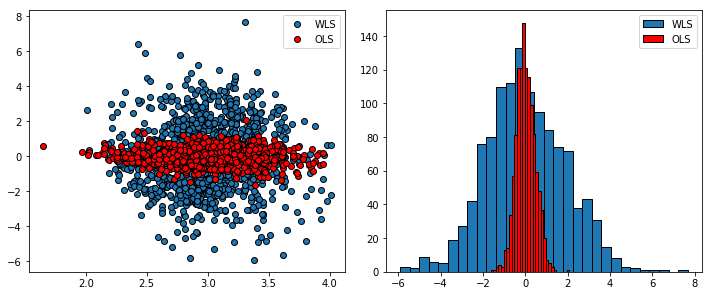

In [105]:
fig = plt.figure(num = 9, figsize = (10, 8))
# Plot fitted vs residual plots:
ax = fig.add_subplot(2, 2, 1)
ax.plot(mdl_4_wls_fit.fittedvalues, e_star, linestyle = "None", marker = "o", markeredgecolor = "black", label = "WLS")
ax.plot(mdl_4_fit.fittedvalues, mdl_4_fit.resid, linestyle = "None", marker = "o", color = "red", markeredgecolor = "black", label = "OLS")
ax.legend()
# Plot the residual histogram
ax = fig.add_subplot(2, 2, 2)
ax.hist(e_star, bins = 30, edgecolor = "black", label = "WLS")
ax.hist(mdl_4_fit.resid, bins = 30, edgecolor = "black", color = "red", label = "OLS")
ax.legend()
# Fix layout in case the labels do overlap:
plt.tight_layout()
plt.show()

We do note that the residual variance is larger **in the transformed data**. Generally, we would hope that WLS (and (F)GLS) would reduce the variance of the residuals. This may indicate, that we need different weights. Newertheless, for now, we will use the WLS model.

Looking at it in a bit more detail:

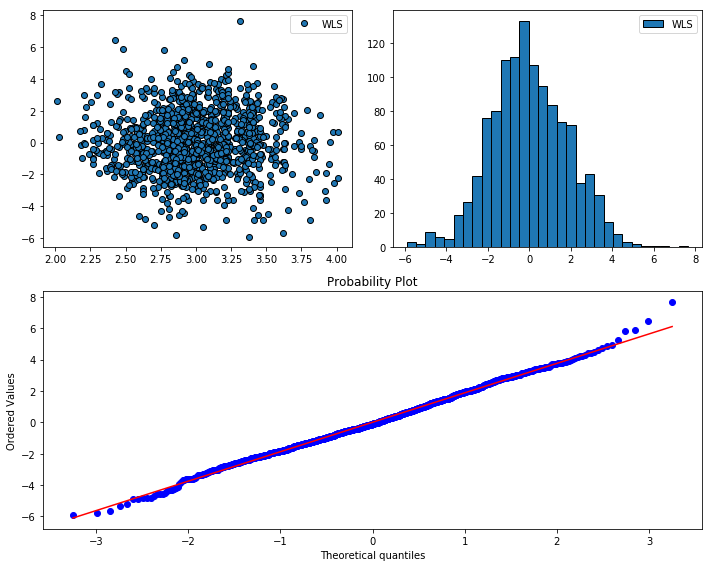

In [106]:
fig = plt.figure(num = 10, figsize = (10, 8))
# Plot fitted vs residual plots:
ax = fig.add_subplot(2, 2, 1)
ax.plot(mdl_4_wls_fit.fittedvalues, e_star, linestyle = "None", marker = "o", markeredgecolor = "black", label = "WLS")
ax.legend()
# Plot the residual histogram
ax = fig.add_subplot(2, 2, 2)
ax.hist(e_star, bins = 30, edgecolor = "black", label = "WLS")
ax.legend()
# Plot the residual Q-Q plot:
ax = fig.add_subplot(2, 1, 2)
stats.probplot(e_star, dist = "norm", plot = ax)
# Fix layout in case the labels do overlap:
plt.tight_layout()
plt.show()

Visually, the scatterplot of the residuals **may be better**, but we are not sure. Thankfully, we know some tests, which can help us out.

In [107]:
name = ['LM-stat', 'LM: p-value', 'F-value', 'F:  p-value']
bg_t = sm_diagnostic.acorr_breusch_godfrey(mdl_4_fit, nlags = 2)
print(pd.DataFrame(lzip(name, bg_t)))

             0         1
0      LM-stat  0.110878
1  LM: p-value  0.946070
2      F-value  0.054751
3  F:  p-value  0.946723


In [108]:
BP_t = sm_diagnostic.het_breuschpagan(resid = e_star, exog_het = mdl_1.exog)
print(pd.DataFrame(lzip(['LM statistic', 'p-value',  'F-value', 'F: p-value'], BP_t)))

              0          1
0  LM statistic  20.683869
1       p-value   0.014131
2       F-value   2.319028
3    F: p-value   0.013803


While the $p$-value is larger - we would still reject the null hypothesis that the residuals are homoskedastic. 

So, our WLS procedure did not take into account all of the heteroskedasticity. Since we calculated the weights using the same exogeneous variables, as in the main model, it may be very likely, that the residuals variance depends on some **additional exogeneous variables**, which we did not include in our main model.

Since there are still is some heteroskedasticity - we need to correct our WLS standard errors. We can do this quite easily with:

In [109]:
# Combine WLS and HAC:
#print(mdl_4_wls_fit.get_robustcov_results(cov_type = "HC0").summary())
#print(mdl_4_wls_fit.get_robustcov_results(cov_type = "HC1").summary())
#print(mdl_4_wls_fit.get_robustcov_results(cov_type = "HC2").summary())
print(mdl_4_wls_fit.get_robustcov_results(cov_type = "HC3").summary())

                            WLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.409
Model:                            WLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     64.01
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          1.40e-119
Time:                        02:59:54   Log-Likelihood:                -725.60
No. Observations:                1200   AIC:                             1477.
Df Residuals:                    1187   BIC:                             1543.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4620      0

We would again return to the conclusion that we should remove $educ^2$ as it is insignificant (though we would get different results with `HC0`, `HC1` and `HC2`).

We can conclude the following:
    
- the WLS correction did not take inot account all possible heteroskedasticity.
- After correcting WLS standard errors with HAC, we came to the same conclusion regarding $educ^2$ - we should remove it from our model as it is not significantly different from zero.

-----

-----

-----

While we have carried out all of these tests and different estimation methods, we would still like to account for the remaining heteroskedasticity. To do this we could look at:

- **examine residual vs explanatory variable scatter plots to get better weights** - maybe there is a specific explanatory variable, which we should use as a weight?
- **remove outliers** - if there are a few points which significantly skew the data - we should remove, as long as they are either due to an error, or some kind of exception. On the other hand, the residual vs fitted scatter plot does not indicate that any single outlier could be the **only cause** for heteroskedasticity. So it will most likely not completely fix heteroskedasticity.
- **get additional observations and additional variables** - as we have seen fro the full dataset - there are many more additional variables, and observations, which may result in a different model (as an example, the variable `black` is significant in the full dataset).

-----

-----

-----

For interests sake, if we were to compare the residuals for the original data - they would have minor differences

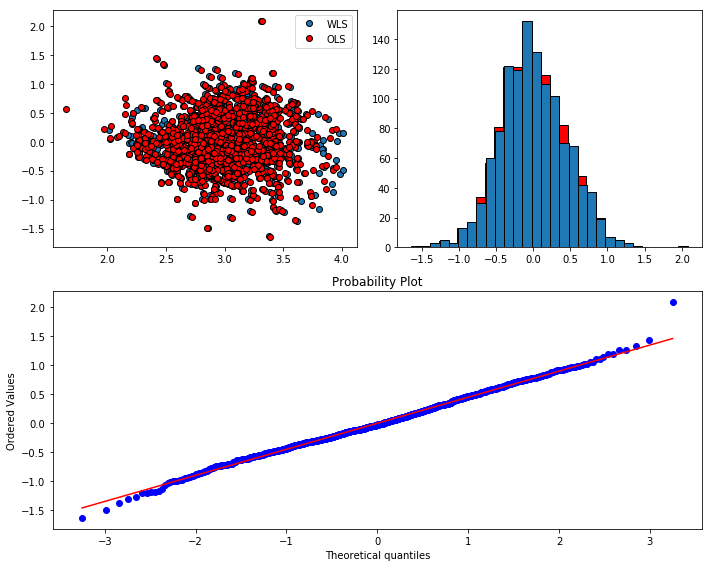

In [110]:
fig = plt.figure(num = 11, figsize = (10, 8))
# Plot fitted vs residual plots:
ax = fig.add_subplot(2, 2, 1)
ax.plot(mdl_4_wls_fit.fittedvalues, mdl_4_wls_fit.resid, linestyle = "None", marker = "o", markeredgecolor = "black", label = "WLS")
ax.plot(mdl_4_fit.fittedvalues, mdl_4_fit.resid, linestyle = "None", marker = "o", color = "red", markeredgecolor = "black", label = "OLS")
ax.legend()
# Plot the residual histogram
ax = fig.add_subplot(2, 2, 2)
ax.hist(mdl_4_fit.resid, bins = 30, edgecolor = "black", color = "red")
ax.hist(mdl_4_wls_fit.resid, bins = 30, edgecolor = "black")
# Plot the residual Q-Q plot:
ax = fig.add_subplot(2, 1, 2)
stats.probplot(mdl_4_wls_fit.resid, dist = "norm", plot = ax)
# Fix layout in case the labels do overlap:
plt.tight_layout()
plt.show()

Again, since WLS fits a model on the transformed data, we are interested if the residuals, from the fitted transformed data adhere to our **(MR.3) - (MR.6)** assumptions.